In [ ]:
#def PCA(M, n):
#    # From: https://medium.com/100-days-of-algorithms/day-92-pca-bdb66840a8fb
#    # Normalize to zero mean:
#    mu = M.mean(axis=0)
#    M= M -mu
#    
#    # Eigenvectors of covariance matrix:
#    # @ -> Matrix multiplication
#    # .T -> Transpose numpy
#    # linalg.eig -> Compute the eigenvalues and right eigenvectors of a square array.
#    sigma = M.T @ M
#    eigvals, eigvecs = np.linalg.eig(sigma)
#    
#    # Principal components:
#    # argsort -> returns the indices that would sort an array. 
#    # [::-1]-> reverse order
#    order = np.argsort(eigvals)[::-1]
#    components = eigvecs[:,order[:n]]
#    
#    # Projection
#    Z = M @ components
#    
#    # result
#    return Z, components

# Imports

In [1]:
import os.path
from math import isnan

import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import container
# from matplotlib.lines import Line2D

from person import Person
from visit import Visit

# from model import create_vae

import tensorflow as tf
from keras import backend as K
from keras.layers import LSTM, Input, RepeatVector
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives

##
from graphs import Graphs
%matplotlib inline

Using TensorFlow backend.


# Constants

In [2]:
%store

Stored variables and their in-db values:
Instructions for updating:
Colocations handled automatically by placer.
g5                  -> '<unavailable>'
persons             -> [<person.Person object at 0x7f1b18e2d160>, <person


In [3]:
# Number of visits to be used in the model
NR_VISITS = 4

# currently read vars from each enroll visit
fields_enroll = ['subjid', 'seq', 'visit', 'age', 'hdcat', 'motscore', 'miscore', 'ocularh', 'ocularv', 'sacinith', 'sacinitv', 'sacvelh', 'sacvelv', 'dysarth', 'tongue',
                 'fingtapr', 'fingtapl', 'prosupr', 'prosupl', 'luria', 'rigarmr', 'rigarml', 'brady', 'dysttrnk', 'dystrue', 'dystlue', 'dystrle', 'dystlle', 'chorface',
                 'chorbol', 'chortrnk', 'chorrue', 'chorlue', 'chorrle', 'chorlle', 'gait', 'tandem', 'retropls', 'tfcscore', 'occupatn', 'finances', 'chores', 'adl', 'carelevl', 'fascore', 'fiscore',
                 'sdmt1', 'sdmt2', 'sit1', 'sit2', 'sit3', 'depscore', 'irascore', 'psyscore', 'aptscore', 'exfscore']

# currently read vars from each profile
fields_profile = ['subjid', 'sex', 'region', 'race', 'hxsid', 'caghigh', 'caglow', 'momhd', 'momagesx', 'dadhd',
                  'dadagesx', 'fhx']

# participation file

fields_participation = ['subjid', 'studyid', 'hdcat_0', 'hdcat_l', 'age_0']


# current vars used in the model
_vars = ['caglow', 'caghigh', 'tfcscore', 'motscore', 'age']
#, 'fascore', 'depscore', 'sdmt1'] 

# Get Data
Get the data from the DB

In [4]:
def get_all_data():
    if os.path.exists('Data/enroll.csv'):
        df = pandas.read_csv('Data/enroll.csv', dtype={"age": str}, usecols=fields_enroll)
        #print(df)
    else:
        print("no file - enroll.csv")

    if os.path.exists('Data/profile.csv'):
        df_p = pandas.read_csv('Data/profile.csv', delimiter='\t', usecols=fields_profile)
        #print(df_p.columns)
    else:
        print("no file - profile.csv")
        
    if os.path.exists('Data/participation.csv'):
        df_part = pandas.read_csv('Data/participation.csv', delimiter='\t', usecols=fields_participation)
    else:
        print("no file - participation.csv")
        
    subjids = {}
    persons = []
    count = 0
    df2 = df.values
    df2_p = df_p.values
    
    for index, i in enumerate(df['subjid']):
        new_visit = Visit()
        if index %10000 ==0:
            print("index %d" % index)
        
        for f in fields_enroll:
            if f == 'age' and  df[df.index==index][f].values == '<18':
                setattr(new_visit, f, '17')
            else:
                setattr(new_visit, f , df[df.index==index][f].values[0])
        
        if i not in subjids:
            # New person

            persons.append(Person(i))
            persons[count].add_visit(new_visit)

            # Count Baseline and FUP only
            if new_visit.visit in ['Baseline', 'Follow Up']:
                persons[count].visits_ok += 1

            # Index in persons array
            count += 1

            # Total visit count
            subjids[i] = 1

        else:
            # Increase counters and add new visit
            subjids[i] += 1
            persons[count-1].add_visit(new_visit)
            if new_visit.visit in ['Baseline', 'Follow Up']:
                persons[count-1].visits_ok += 1
    
    
    for index, i in enumerate(df_p['subjid']):
        for f in fields_profile:
            if f == 'caghigh' and df_p[df_p.index==index][f].values == '>70':
                setattr(persons[index], f, '71')
            elif f == 'caglow' and df_p[df_p.index==index][f].values == '>28':
                setattr(persons[index], f, '29')
            else:
                setattr(persons[index], f, df_p[df_p.index==index][f].values[0])
    
    new_df = df_part[df_part.studyid=='ENR']
    for index, i in enumerate(new_df['subjid']):
        setattr(persons[index], 'state', new_df[new_df.subjid==i]['hdcat_l'].values[0])
    
    return persons

    

In [5]:
persons = get_all_data()
%store persons

index 0
index 10000
index 20000
index 30000
index 40000
Stored 'persons' (list)


In [5]:
%store -r persons

In [6]:
len(persons)

15301

In [7]:
def get_data(persons):
    pre = 0
    post = 0
    control = 0

    nr_vis_ok = {}
    nr_vis = {}

    list_visits = []
    list_pre = []
    list_post = []
    list_control = []

    # counters  for each of the 3 groups
    for ind,i in enumerate(persons):
        setattr(i, 'p_ind',ind)
        if i.state == 2:
            pre += 1
        elif i.state == 3:
            post += 1
        elif i.state in [4,5]:
            control += 1

        if i.visits_ok not in nr_vis_ok:
            nr_vis_ok[i.visits_ok] = 1
        else:
            nr_vis_ok[i.visits_ok] += 1
        if i.visits not in nr_vis:
            nr_vis[i.visits] = 1
        else:
            nr_vis[i.visits] += 1

        if i.visits_ok == NR_VISITS:
            # Persons with visits total = visits baseline + FUP desired
            list_visits.append(i)
            # Separated by control, pre-manifest, and post-manifest
            if i.state == 2:
                list_pre.append(i)
            elif i.state == 3:
                list_post.append(i)
            elif i.state in [4,5]:
                list_control.append(i)
        if i.visits_ok > NR_VISITS:
            for x in range(i.visits_ok - NR_VISITS +1):
                if i.visit_list[x].visit in ['Baseline', 'Follow Up'] and i.visit_list[x+1].visit == 'Follow Up' and \
                i.visit_list[x+2].visit == 'Follow Up' and i.visit_list[x+3].visit == 'Follow Up':
                    list_visits.append(i)
                    if i.state==2:
                        list_pre.append(i)
                    elif i.state == 3:
                        list_post.append(i)
                    elif i.state in [4,5]:
                        list_control.append(i)
                    # only add the first NR_VISITS good, in case there are more combinations
                    #break
    

    # Data #
    
    #Info#
    pre_caghigh=0
    pre_caglow=0
    pre_bothcag=0
    pre_underage=0
    post_caghigh=0
    post_caglow=0
    post_bothcag=0
    post_underage=0
    control_caghigh=0
    control_caglow=0
    control_bothcag =0
    control_underage =0
    
    for p in persons:
        if p.state == 2:
            #pre
            if p.visit_list[0].age == '17':
                pre_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    pre_caghigh +=1
                if p.caglow == '29':
                    pre_caglow +=1
        elif p.state == 3:
            #post
            if p.visit_list[0].age == '17':
                post_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    post_caghigh +=1
                if p.caglow == '29':
                    post_caglow +=1
        elif p.state in [4,5]:
            #control
            if p.visit_list[0].age == '17':
                control_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                control_bothcag +=1
            else:
                if p.caghigh == '71':
                    control_caghigh +=1
                if p.caglow == '29':
                    control_caglow +=1
    
    print("From total data: %d controls, %d Pre, %d post: \n" % (control, pre, post))
    print("Controls: caghigh - %d    caglow - %d  both - %d" % (control_caghigh, control_caglow, control_bothcag))
    print("Pre: caghigh - %d    caglow - %d both - %d" % (pre_caghigh, pre_caglow, pre_bothcag))
    print("Post: caghigh - %d    caglow - %d  both - %d" % (post_caghigh, post_caglow, post_bothcag))
    print("Underage: Control %d ; Pre %d ; Post %d \n" % (control_underage, pre_underage, post_underage))
    
    pre_caghigh=0
    pre_caglow=0
    pre_bothcag=0
    pre_underage=0
    post_caghigh=0
    post_caglow=0
    post_bothcag=0
    post_underage=0
    control_caghigh=0
    control_caglow=0
    control_bothcag =0
    control_underage =0
    
    for p in list_visits:
        if p.state == 2:
            #pre
            if p.visit_list[0].age == '17':
                pre_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    pre_caghigh +=1
                if p.caglow == '29':
                    pre_caglow +=1
        elif p.state == 3:
            #post
            if p.visit_list[0].age == '17':
                post_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    post_caghigh +=1
                if p.caglow == '29':
                    post_caglow +=1
        elif p.state in [4,5]:
            #control
            if p.visit_list[0].age == '17':
                control_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                control_bothcag +=1
            else:
                if p.caghigh == '71':
                    control_caghigh +=1
                if p.caglow == '29':
                    control_caglow +=1
    
    
    print("From data to be used: %d controls, %d Pre, %d post: \n" % (len(list_control),  len(list_pre), len(list_post)))
    print("Controls: caghigh - %d    caglow - %d  both - %d" % (control_caghigh, control_caglow, control_bothcag))
    print("Pre: caghigh - %d    caglow - %d both - %d" % (pre_caghigh, pre_caglow, pre_bothcag))
    print("Post: caghigh - %d    caglow - %d  both - %d" % (post_caghigh, post_caglow, post_bothcag))
    print("Underage: Control %d ; Pre %d ; Post %d \n" % (control_underage, pre_underage, post_underage))

    # For the model #
    
    control_data = np.zeros(shape=(len(list_control), NR_VISITS, len(_vars)))
    pre_data = np.zeros(shape=(len(list_pre), NR_VISITS, len(_vars)))
    post_data = np.zeros(shape=(len(list_post), NR_VISITS, len(_vars)))

    control_labels = np.zeros(shape=(len(list_control), 1))
    pre_labels = np.zeros(shape=(len(list_pre), 1))
    post_labels = np.zeros(shape=(len(list_post), 1))

    for index, i in enumerate(list_control):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                for k, var in enumerate(_vars):
                    try:
                        control_data[index,c,k] = getattr(j,var)
                    except:
                        control_data[index,c,k] = getattr(i,var)              
                c += 1
                if c == NR_VISITS:
                    break
        control_labels[index] = i.p_ind

    for index, i in enumerate(list_pre):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                for k, var in enumerate(_vars):
                    try:
                        pre_data[index,c,k] = getattr(j,var)
                    except:
                        pre_data[index,c,k] = getattr(i,var)               
                c += 1
                if c == NR_VISITS:
                    break
        pre_labels[index] = i.p_ind

    for index, i in enumerate(list_post):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                for k, var in enumerate(_vars):
                    try:
                        post_data[index,c,k] = getattr(j,var)
                    except:
                        post_data[index,c,k] = getattr(i,var)                    
                c += 1
                if c == NR_VISITS:
                    break
        post_labels[index] = i.p_ind

    control_data = control_data.astype('float32')
    pre_data = pre_data.astype('float32')
    post_data = post_data.astype('float32')


    # Entries to be removed from the used data - ones with nan values on the required fields or missing/wrong 999* and outliers -> age =17,
    # caghigh = 71, caglow = 29 
    
    print("Removing the unwanted data from controls \n")
    to_del = []
    
    for index, x1 in np.ndenumerate(control_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996] or (x1 == 71 and index[2] == 1) or (x1 == 29 and index[2] == 0) or (x1 == 17 and index[2]==4):
            if index[0] not in to_del:
                to_del.append(index[0])
                
    print("Removing %d entries from control data" % len(to_del))
    print("Old control -> %s" % (control_data.shape,))
    control_data = np.delete(control_data, to_del, 0)
    control_labels = np.delete(control_labels, to_del, 0)
    print("New control -> %s\n" % (control_data.shape,))
    
    print("Removing the unwanted data from pre \n")
    to_del = []
    for index, x1 in np.ndenumerate(pre_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996] or (x1 == 71 and index[2] == 1) or (x1 == 29 and index[2] == 0) or (x1 == 17 and index[2]==4):
            if index[0] not in to_del:
                to_del.append(index[0])
    
    print("Removing %d entries from pre data" % len(to_del))
    print("Old pre -> %s" % (pre_data.shape,))
    pre_data = np.delete(pre_data, to_del, 0)
    pre_labels = np.delete(pre_labels, to_del, 0)
    print("New pre -> %s\n" % (pre_data.shape,))
    
    print("Removing the unwanted data from post \n")
    
    to_del = []
    for index, x1 in np.ndenumerate(post_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996] or (x1 == 71 and index[2] == 1) or (x1 == 29 and index[2] == 0) or (x1 == 17 and index[2]==4):
            if index[0] not in to_del:
                to_del.append(index[0])
                
    print("Removing %d entries from post data" % len(to_del))
    print("Old post -> %s" % (post_data.shape,))
    post_data = np.delete(post_data, to_del, 0)
    post_labels = np.delete(post_labels, to_del, 0)
    print("New post -> %s\n" % (post_data.shape,))
    
    # mean and std #

    std = control_data.std(axis=0)
    mean = control_data.mean(axis=0)

    std_pre = pre_data.std(axis=0)
    mean_pre = pre_data.mean(axis=0)

    std_post = post_data.std(axis=0)
    mean_post = post_data.mean(axis=0)
    #Graphs.generate_profile_plots(persons)
    #Graphs.generate_vars_plots(_vars,mean, mean_pre, mean_post, std, std_pre, std_post, control_data, pre_data, post_data, NR_VISITS)
    
    return control_data, pre_data, post_data, mean, std, control_labels, pre_labels, post_labels


# Data Info
Generate some info on the data acquired

In [8]:
# Normalization:
def do_norm(mean, std, control_data, pre_data, post_data):
    std= np.where(std==0,np.inf,std)
    control_data -= mean
    control_data /= std
    #control_data = np.nan_to_num(control_data)  
    pre_data -= mean
    pre_data /= std
    pre_data = np.nan_to_num(pre_data)
    post_data -= mean
    post_data /= std
    post_data = np.nan_to_num(post_data)

# Network

## Model definition 

In [9]:
# model #

# based on https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py 
# and https://blog.keras.io/building-autoencoders-in-keras.html 

def create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta):
    
    x = Input(shape=(timesteps, input_dim))     # Inputs
    
    #h = LSTM(intermediate_dim)(x)
    
    #print("x-> " + str(x.shape))
    h = LSTM(intermediate_dim, return_sequences=True)(x)       # LSTM output
    #print("h1->" + str(h.shape))
    h = LSTM(int(intermediate_dim/2), return_sequences=True)(h)
    #print("h2->" + str(h.shape))
    h = LSTM(int(intermediate_dim/4))(h)

    # Latent space
    z_mean = Dense(latent_dim, activation='linear')(h)
    z_log_sigma = Dense(latent_dim, activation='softplus')(h)

    # Sampling

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    # decoded LSTM layer
    
    #h_decoded = RepeatVector(timesteps)(z)
    #h_decoded = LSTM(intermediate_dim, return_sequences=True)(h_decoded)
    
    
    decoder_h = LSTM(int(intermediate_dim/4), return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)
    h_decoded = LSTM(int(intermediate_dim/2), return_sequences=True)(h_decoded)
    h_decoded = LSTM(intermediate_dim, return_sequences=True)(h_decoded)
    
    x_decoded_mean = Dense(input_dim, activation='linear')(h_decoded)
    

    # end-to-end autoencoder

    vae = Model(x, x_decoded_mean)

    # encoder: inputs to latent space

    encoder = Model(x, z_mean)

    # generator: from latent space to reconstructed inputs

    decoder_input = Input(shape=(latent_dim, ))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    
    #_h_decoded = LSTM(intermediate_dim,return_sequences=True)(_h_decoded)
    
    _h_decoded = LSTM(int(intermediate_dim/4), return_sequences=True)(_h_decoded)
    _h_decoded = LSTM(int(intermediate_dim/2), return_sequences=True)(_h_decoded)
    _h_decoded = LSTM(intermediate_dim, return_sequences=True)(_h_decoded)

    _x_decoded_mean = Dense(input_dim, activation='linear')(_h_decoded)

    generator = Model(decoder_input, _x_decoded_mean)

    def vae_loss(x, x_decoded_mean):
        xent_loss = objectives.mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss * beta
        return loss
    # run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    #vae.compile(optimizer='adam', loss=vae_loss, options=run_opts)
    vae.compile(optimizer='adam',loss=vae_loss)

    return vae, encoder, generator, z_mean, z_log_sigma

## Running the model

In [8]:
    # Run the model #
%matplotlib inline
    def do_run(control_data, pre_data, post_data, mean, std, control_labels, pre_labels, post_labels):
        input_dim = len(_vars)  # vars
        timesteps = NR_VISITS  # visits
        #batch_size =   64 # 
        epsilon_std = 1.  #
        #latent_dim = 1000  #
        epochs = 200 #
        #intermediate_dim =   #
        #beta = 0.5 # Param for KL loss
        
    
        b_list=[256,512]
        i_list=[128,256,512]
        l_list=[len(_vars)//4+1,len(_vars)//2,len(_vars)]
        beta_list = [0,0.5,1]
        g = []
        c=1
        top = "%d vars" % (len(_vars))
        #os.mkdir(top)
        for index1,batch_size in enumerate(b_list):
            for index2,intermediate_dim in enumerate(i_list):
                for index3,latent_dim in enumerate(l_list):
                    for index4, beta in enumerate(beta_list):
                        try:
                            del vae
                            del gen
                            del enc
                            tf.reset_default_graph()
                            K.clear_session()
                        except:
                            pass
                        
                        name = "%s/%d_%d_%d_%.2f" %(top,batch_size, intermediate_dim, latent_dim, beta)
                        
                        #Model creation
                        vae, enc, gen = create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta)
                        #vae.summary()
                        
                        #Shuffling data and labels (subjid)
                        shuffle(control_data,control_labels)
                        
                        #Running the model
                        history = vae.fit(control_data, control_data, epochs=150, validation_split=0.2, batch_size=batch_size, verbose=0)
                        preds = vae.predict(control_data,batch_size = batch_size)
                        preds_pre = vae.predict(pre_data,batch_size = batch_size)
                        preds_post = vae.predict(post_data,batch_size = batch_size)
                        
                        #Plotting
                        _,p1=Graphs.plot_loss(batch_size,intermediate_dim, latent_dim,beta, history)
                        #p1.savefig(name+'_loss.png')
                        p1.show()
                        #plt.close(p1)
                        p2=Graphs.plot_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons)
                        #p2.savefig(name+'_PCA.png')
                        p2.show()
                        #plt.close(p2)
                        p3=Graphs.plot_TSNE(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons)
                        #Graphs.generate_pred_plots(control_data, preds, pre_data, preds_pre, post_data,preds_post, _vars, mean, std, NR_VISITS)
                        
                        
                        
                        #p3.savefig(name+'_TSNE.png')                
                        p3.show()
                        #plt.close(p3)
                       
                       #vae, enc, gen = create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta)
                       #np.random.shuffle(control_data)
                       #history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=0)
                       #preds = vae.predict(control_data, batch_size=batch_size)
                        print("%d -> (%d, %d, %d); -- %f %f" % (c,batch_size,intermediate_dim,latent_dim, min(history.history['loss']), min(history.history['val_loss'])))
                        c +=1
                        g.append((batch_size, intermediate_dim,latent_dim, beta, history))
        return g, (vae,enc,gen)

    

In [9]:
def do_print(g):
    min_f= 10000
    i_f=(0,0,0,0)
    for i in g:
        (min_l, min_v) = Graphs.plot_loss(i[0], i[1],i[2],i[3],i[4])
        print(min_l, min_v)
        if min_v>min_l and min_l < min_f:
        #if min_l<min_f:
            min_f = min_l
            i_f = i
    print("The best run, with min loss = %f was -> Batch size = %d, intermediate dim = %d and Latent dim = %d; beta -> %d. Running it now with more epochs and plots."\
          % (min_f, i[0],i[1],i[2],i[3]))
    return(i_f)

In [ ]:
#_vars = ['caghigh', 'age', 'ocularh', 'ocularv','sacinith', 'sacinitv', 'sacvelh', 'sacvelv', 'dysarth', 'tongue','fingtapr', 'fingtapl', 'prosupr','prosupl', 'luria', 
#         'rigarmr', 'rigarml','brady', 'dysttrnk',  'dystrue', 'dystlue', 'dystrle', 'dystlle', 'chorface', 'chorbol', 'chortrnk', 'chorrue', 'chorlue', 'chorrle', 'chorlle', 'gait', 'tandem', 'retropls']
#
#NR_VISITS = 4
#control_data, pre_data, post_data, mean, std, control_labels, pre_labels, post_labels = get_data(persons)
#do_norm(mean, std, control_data, pre_data, post_data)
#g5,m5 = do_run(control_data, pre_data, post_data, mean, std, control_labels, pre_labels, post_labels)
#

## Runs


From total data: 3719 controls, 3186 Pre, 8396 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 44 both - 0
Post: caghigh - 28    caglow - 163  both - 0
Underage: Control 4 ; Pre 2 ; Post 25 

From data to be used: 1138 controls, 829 Pre, 2636 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 16 both - 0
Post: caghigh - 6    caglow - 55  both - 0
Underage: Control 2 ; Pre 2 ; Post 6 

Removing the unwanted data from controls 

Removing 84 entries from control data
Old control -> (1138, 4, 38)
New control -> (1054, 4, 38)

Removing the unwanted data from pre 

Removing 36 entries from pre data
Old pre -> (829, 4, 38)
New pre -> (793, 4, 38)

Removing the unwanted data from post 

Removing 243 entries from post data
Old post -> (2636, 4, 38)
New post -> (2393, 4, 38)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Para

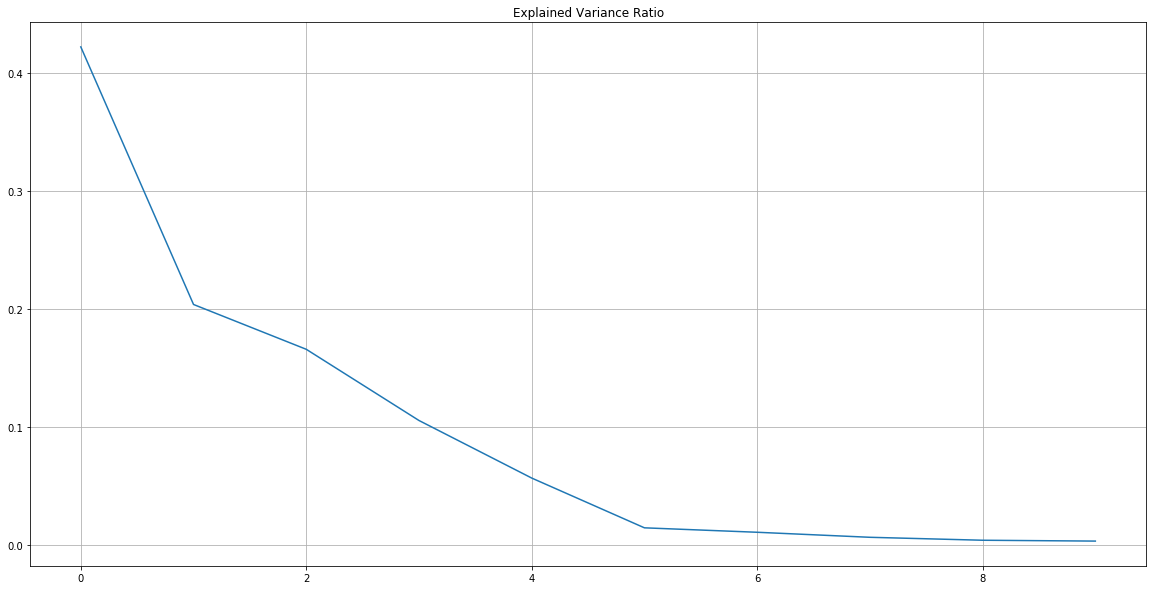


 Min ->  10.94149524760696


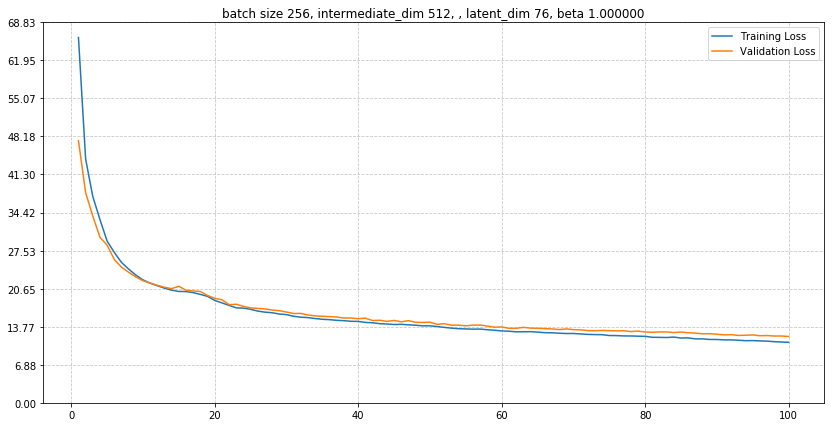

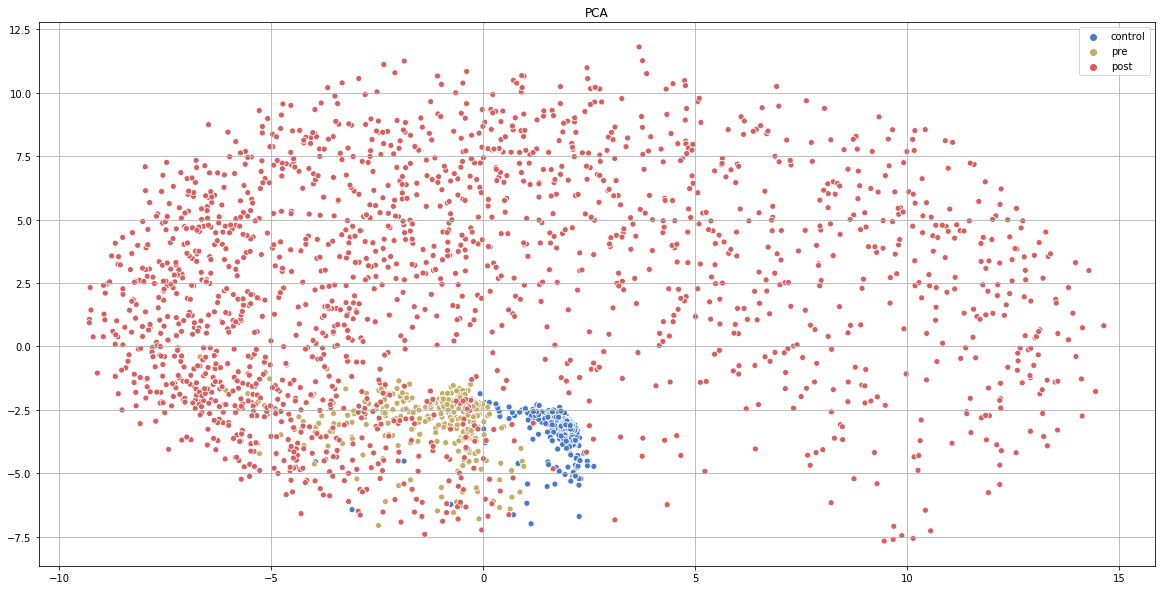

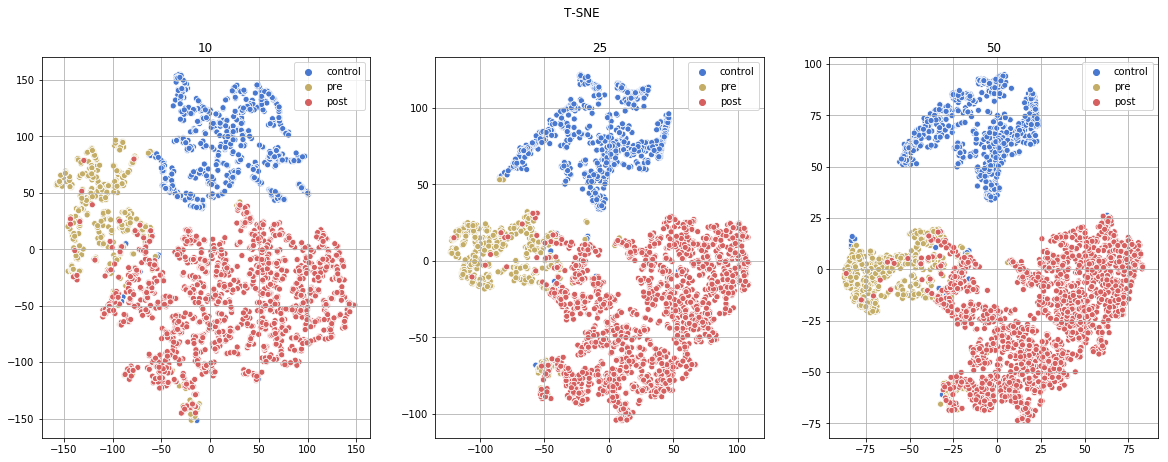

In [10]:
%matplotlib inline
_vars = ['caghigh', 'age', 'occupatn', 'finances', 'chores', 'adl', 'carelevl', 'ocularh', 'ocularv','sacinith', 'sacinitv', 'sacvelh', 'sacvelv', 'dysarth', 'tongue','fingtapr', 'fingtapl', 'prosupr','prosupl', 'luria', 
         'rigarmr', 'rigarml','brady', 'dysttrnk',  'dystrue', 'dystlue', 'dystrle', 'dystlle', 'chorface', 'chorbol', 'chortrnk', 'chorrue', 'chorlue', 'chorrle', 'chorlle', 'gait', 'tandem', 'retropls']
#_vars = ['caghigh', 'tfcscore', 'age','depscore', 'irascore', 'aptscore', 'exfscore','psyscore']
#_vars = ['caglow', 'caghigh', 'tfcscore', 'motscore', 'age']
NR_VISITS = 4
control_data, pre_data, post_data, mean, std, control_labels, pre_labels, post_labels = get_data(persons)
do_norm(mean, std, control_data, pre_data, post_data)

batch = 256
i_dim = 512
l_dim=2*len(_vars)
beta=1

try:
    del vae
    del gen
    del enc
except:
    pass
tf.reset_default_graph()
K.clear_session()

data = np.concatenate((control_data,pre_data,post_data))
labels = np.concatenate((control_labels, pre_labels, post_labels))
#Model creation
vae, enc, gen,_,_ = create_vae(len(_vars), NR_VISITS, batch, i_dim, l_dim, 1.0, beta)
vae.summary()

#Shuffling data and labels (subjid)
data, labels = shuffle(data,labels)

#Running the model
history = vae.fit(data, data, epochs=100, validation_split=0.2, batch_size=batch, verbose=0)
p0 = Graphs.explain_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons, n_components=10)
#p0.show()
#plt.clf()
preds = vae.predict(control_data, batch_size=batch)
preds_pre = vae.predict(pre_data, batch_size=batch)
preds_post = vae.predict(post_data, batch_size=batch)

#Plotting
_,p1=Graphs.plot_loss(batch,i_dim, l_dim,beta, history)
#p1.show()
#plt.clf()
#p2=Graphs.plot_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons)
#p2.show()
#plt.clf()

pca = PCA(n_components=2)
l0 = enc.predict(control_data)
l1 = enc.predict(pre_data)
l2 = enc.predict(post_data)

l= np.concatenate((l0,l1,l2))

z = pca.fit_transform(l)

Y = ['control'] *control_data.shape[0]  + ['pre'] * pre_data.shape[0] + ['post'] * post_data.shape[0]
muted    = ["#4878CF", "#6ACC65", "#D65F5F", "#B47CC7", "#C4AD66", "#77BEDB"]
newPal   = dict(control = muted[0], pre = muted[4], post = muted[2])

f=plt.figure(figsize=(20,10))
plt.grid()
sns.scatterplot(z[:,0], z[:,1], hue=Y,palette=newPal)
plt.title("PCA")
plt.show()


p3=Graphs.plot_TSNE(enc, control_data, pre_data, post_data, control_labels, pre_labels, post_labels, persons)
#p3.show()
#plt.clf()

#Graphs.plot_mse(control_data, preds, pre_data, preds_pre, post_data,preds_post, _vars, mean, std, NR_VISITS)


From total data: 3719 controls, 3186 Pre, 8396 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 44 both - 0
Post: caghigh - 28    caglow - 163  both - 0
Underage: Control 4 ; Pre 2 ; Post 25 

From data to be used: 1138 controls, 829 Pre, 2636 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 16 both - 0
Post: caghigh - 6    caglow - 55  both - 0
Underage: Control 2 ; Pre 2 ; Post 6 

Removing the unwanted data from controls 

Removing 84 entries from control data
Old control -> (1138, 4, 38)
New control -> (1054, 4, 38)

Removing the unwanted data from pre 

Removing 36 entries from pre data
Old pre -> (829, 4, 38)
New pre -> (793, 4, 38)

Removing the unwanted data from post 

Removing 243 entries from post data
Old post -> (2636, 4, 38)
New post -> (2393, 4, 38)

Explained variance ratio:
[0.45547414 0.3119857  0.13403781 0.05524296 0.01229526 0.00915562
 0.00446912 0.00385515 0.00279482 0.00132581]


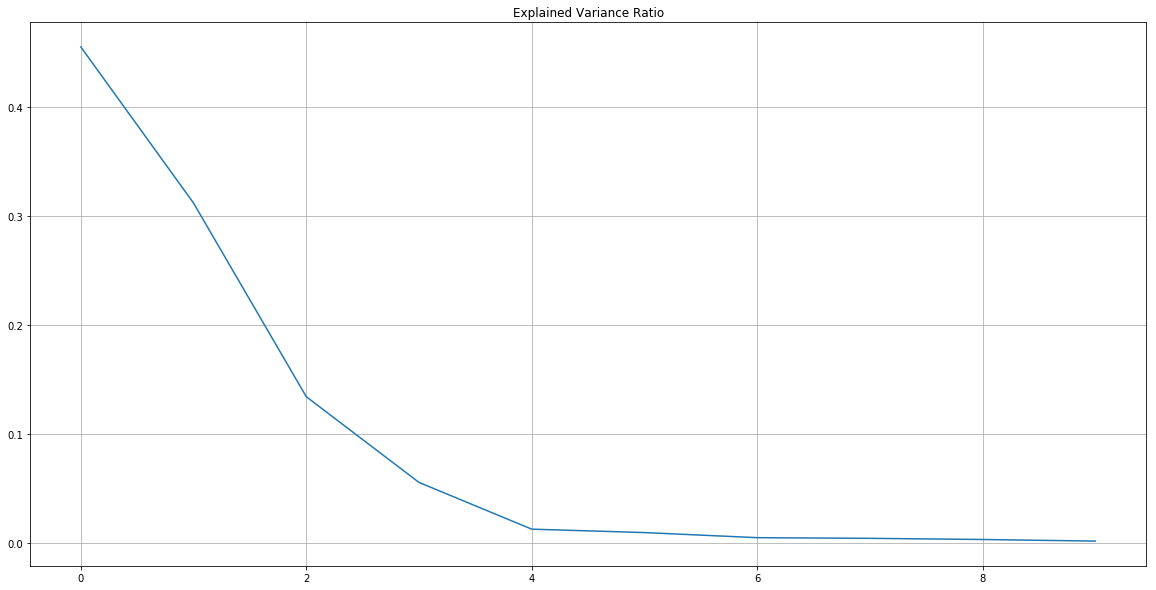


 Min ->  0.47087347507476807


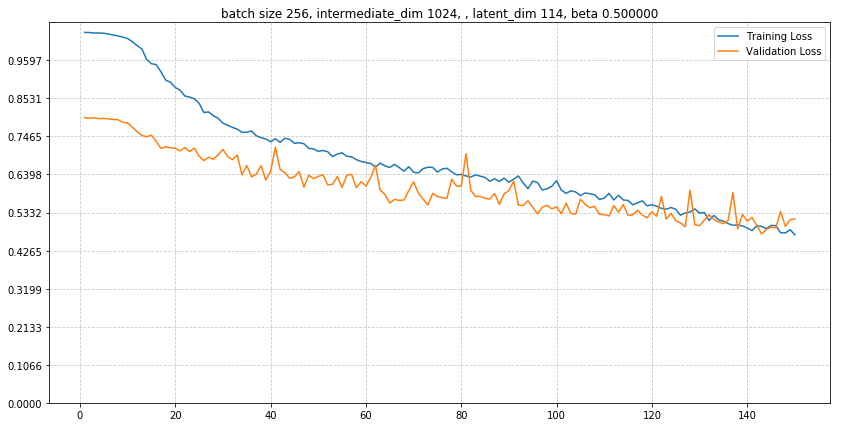

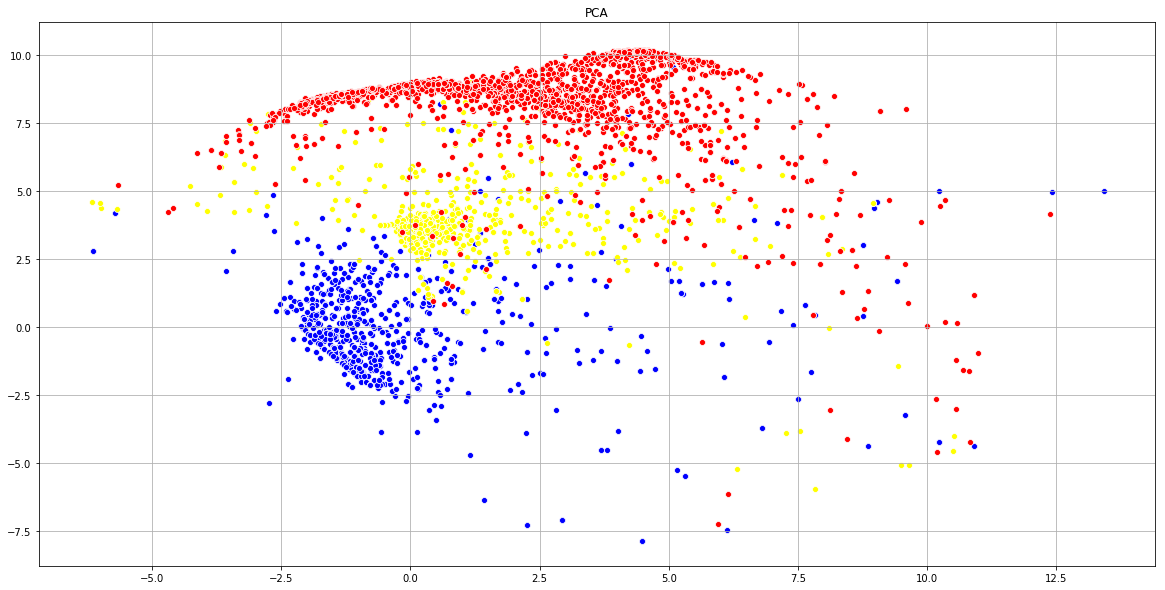

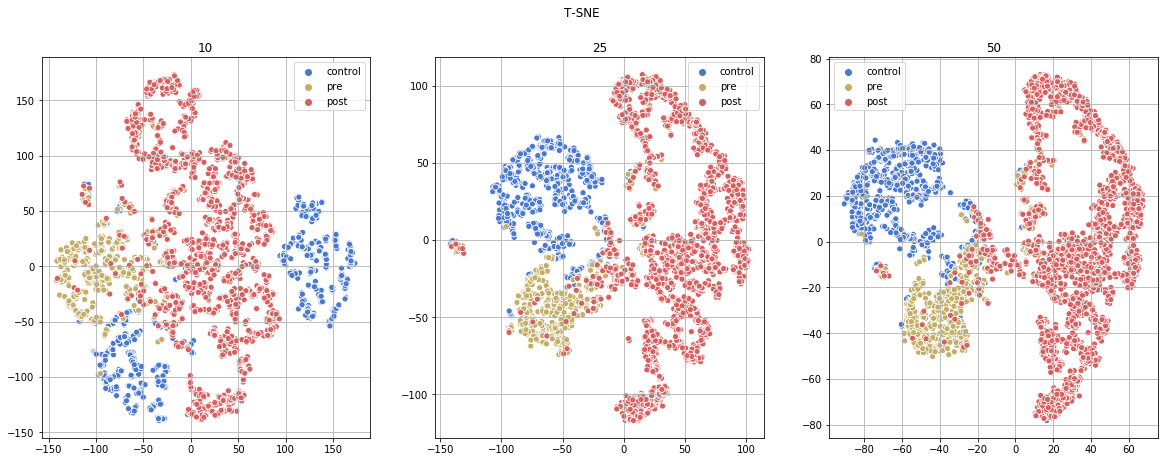

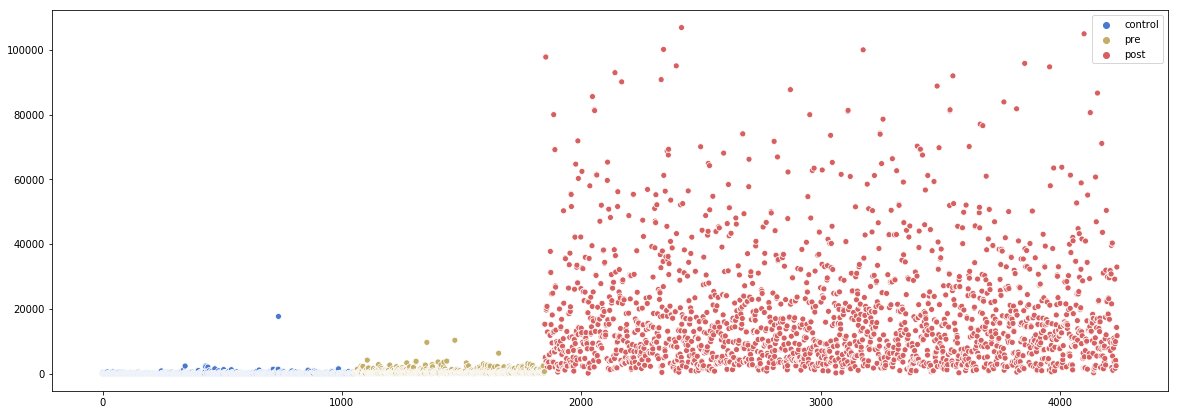

Explained variance ratio:
[0.24987768 0.22899334 0.1730425  0.13733341 0.10089964 0.05843034
 0.01528889 0.01007589 0.00454453 0.0034221 ]


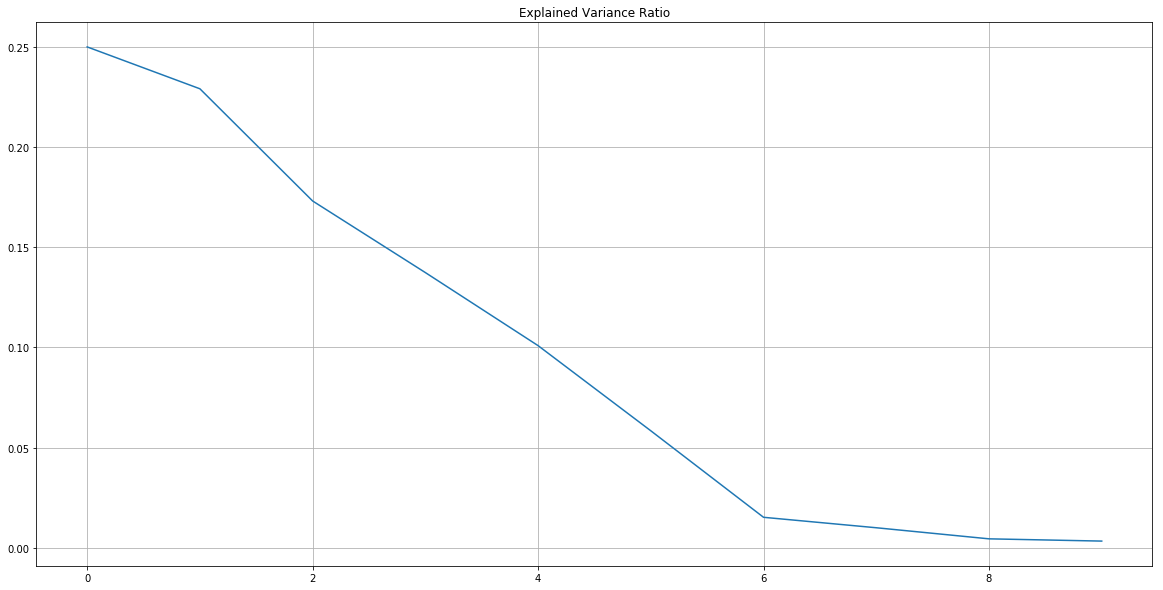


 Min ->  0.4100603069744858


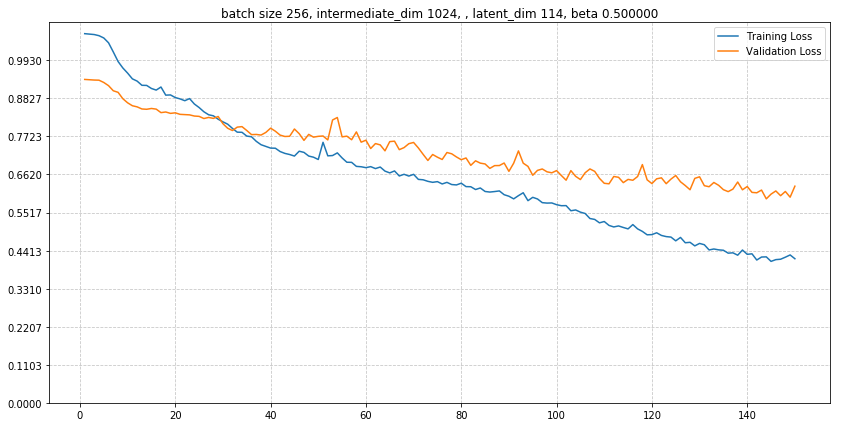

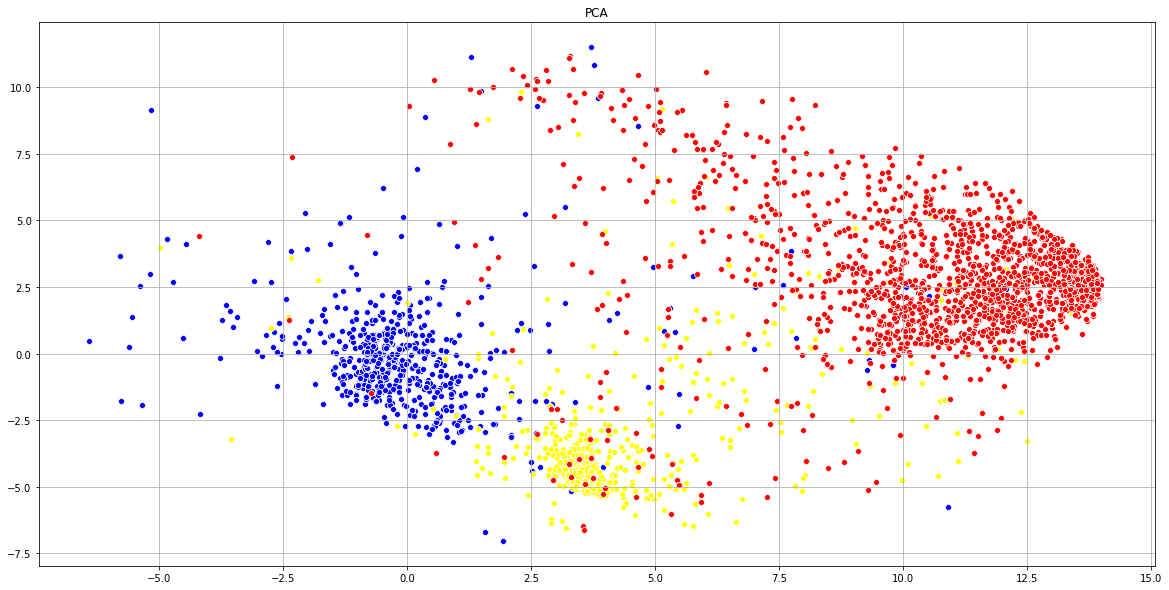

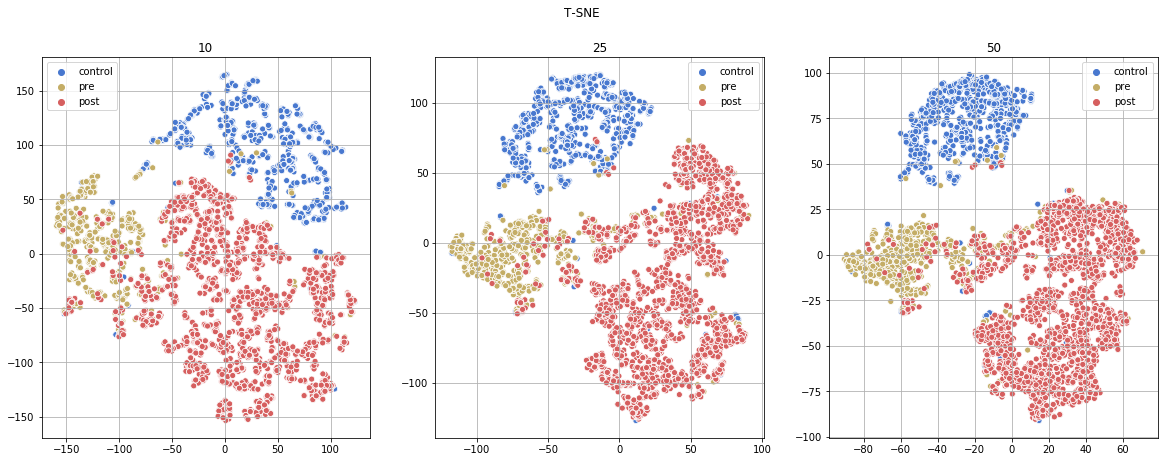

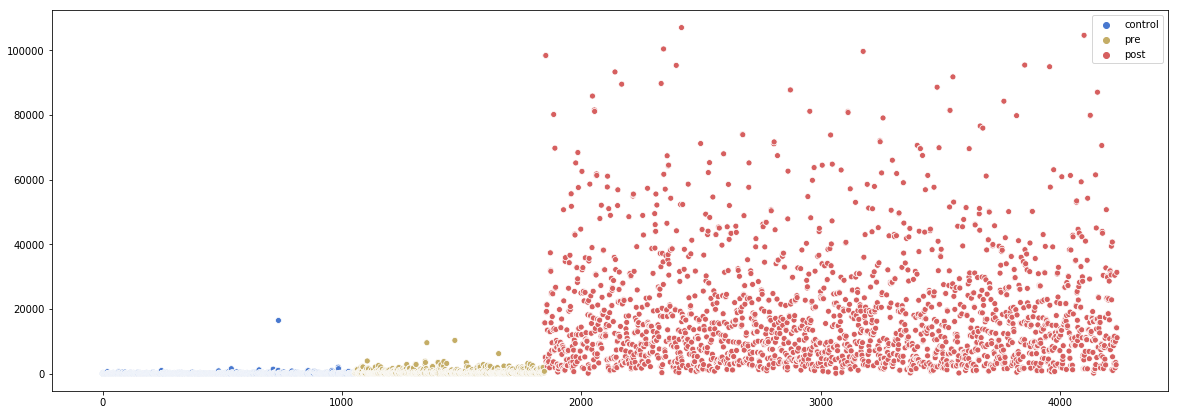

Explained variance ratio:
[0.23316835 0.19521226 0.152533   0.14419578 0.1341136  0.07473715
 0.03591611 0.0060004  0.00429477 0.00237334]


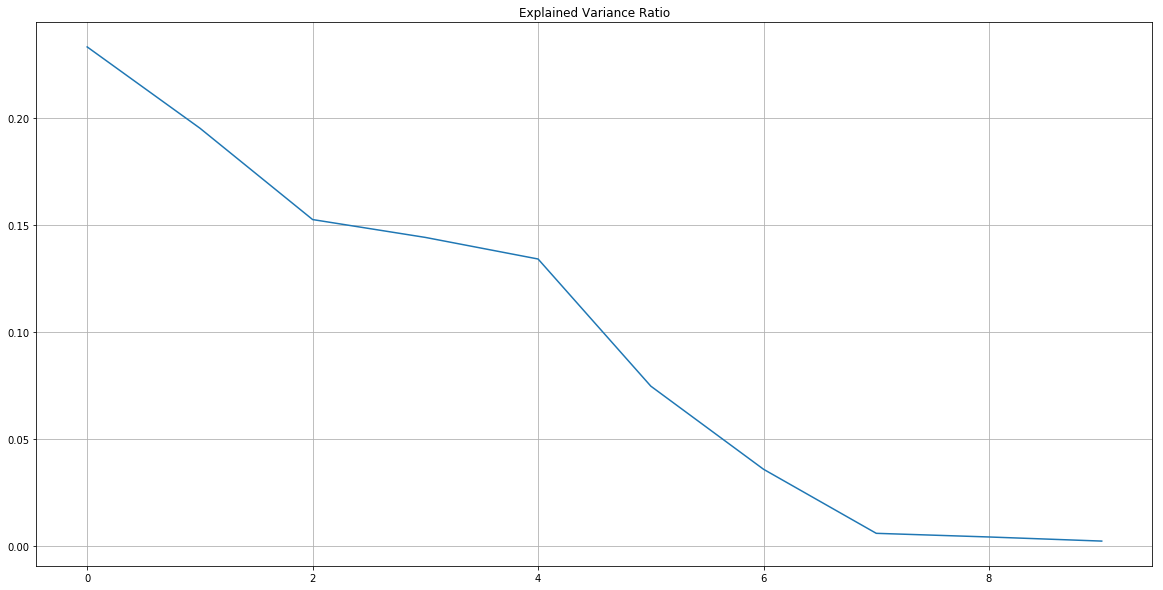


 Min ->  0.49054695425181366


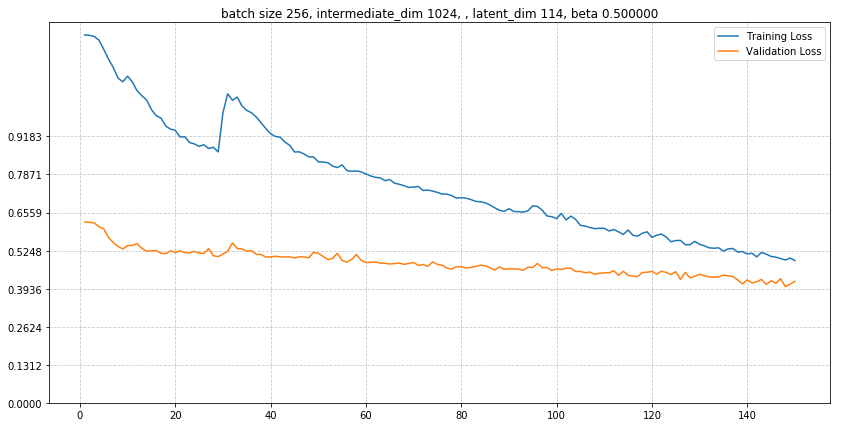

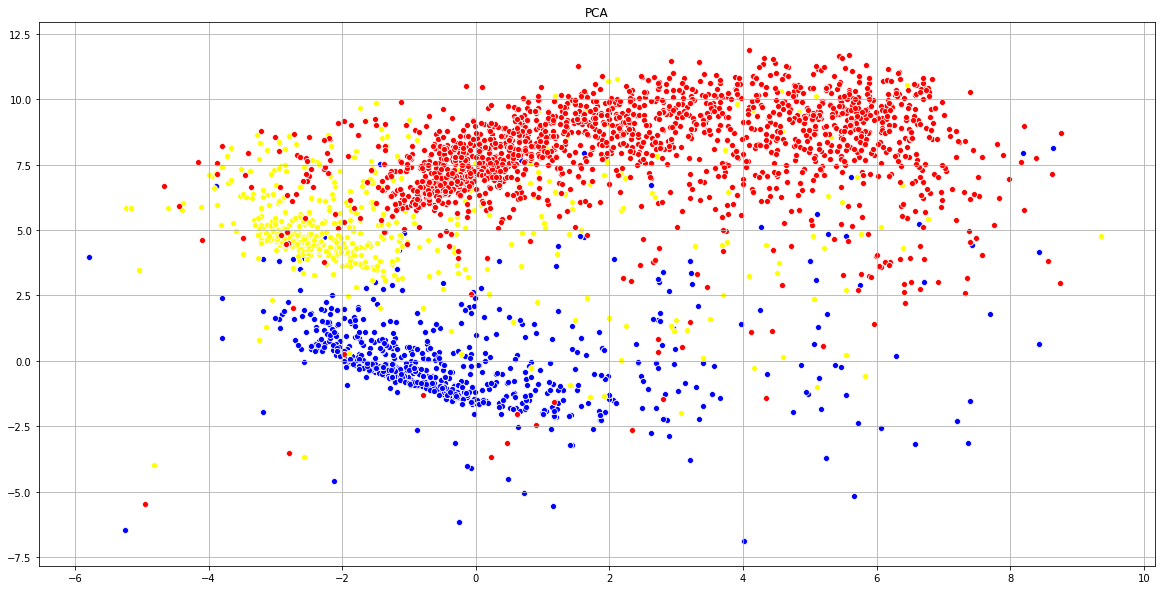

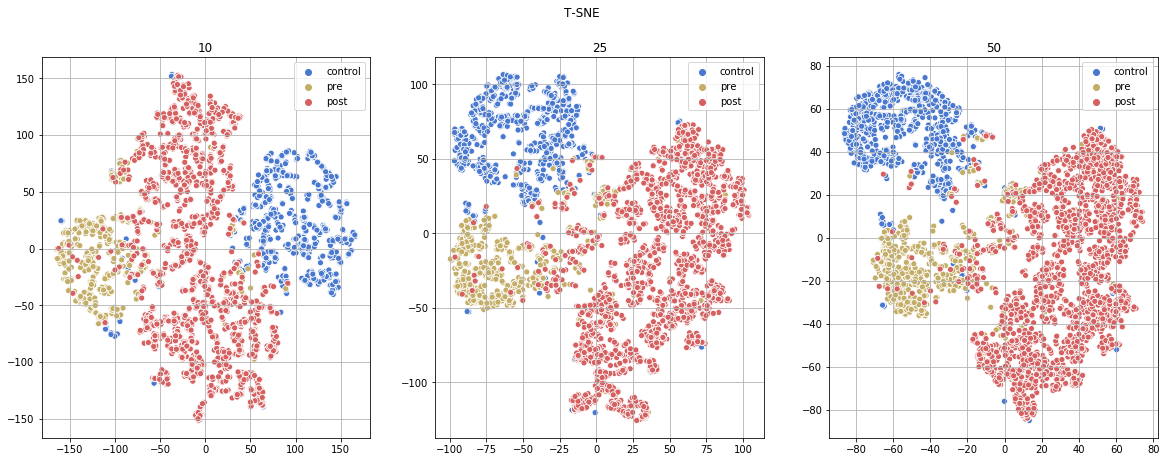

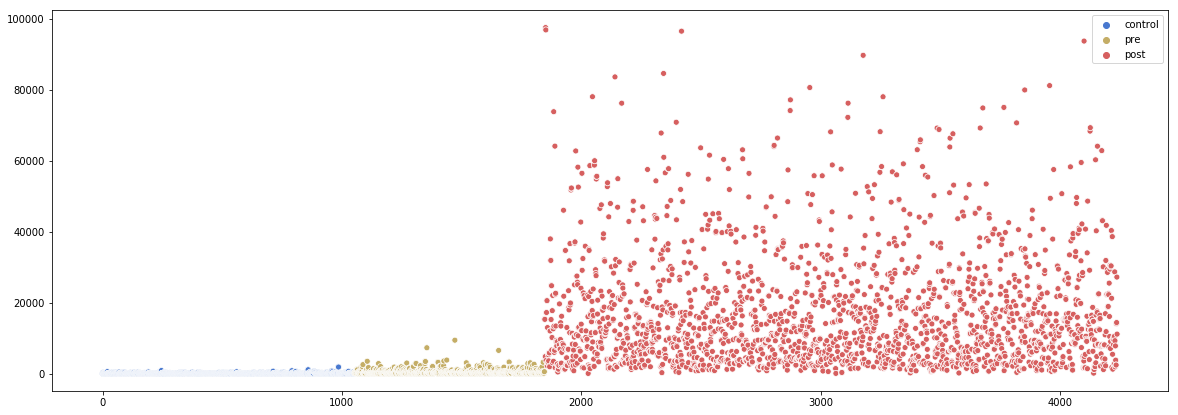

Explained variance ratio:
[0.24638343 0.1790998  0.16645452 0.14282772 0.11950555 0.07875842
 0.03295667 0.00998473 0.00501302 0.00198398]


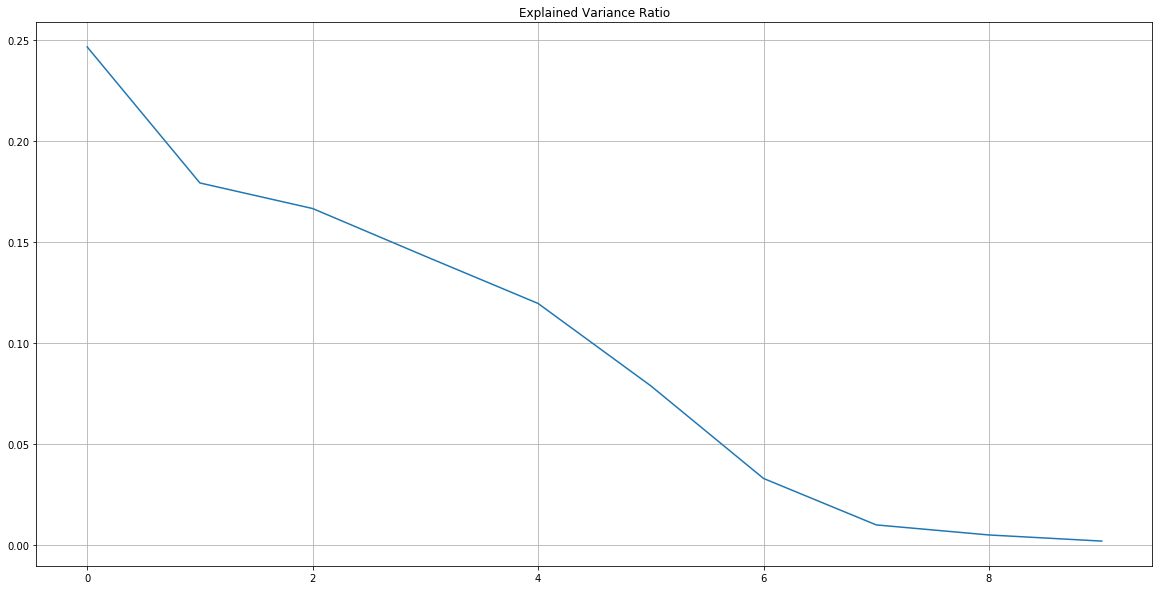


 Min ->  0.4673824574078791


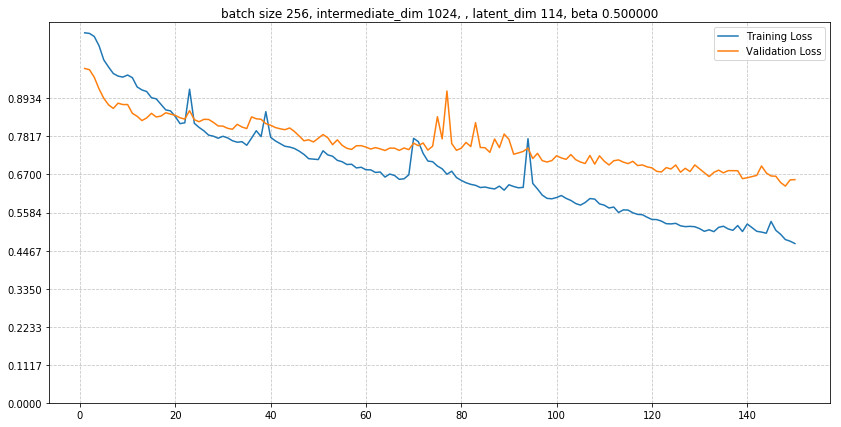

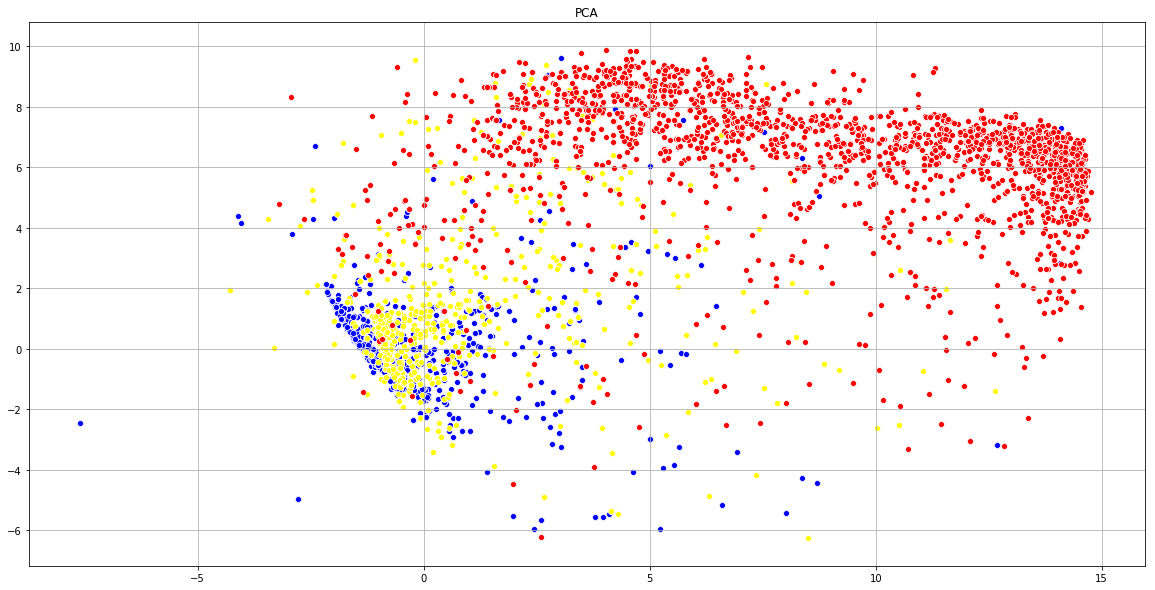

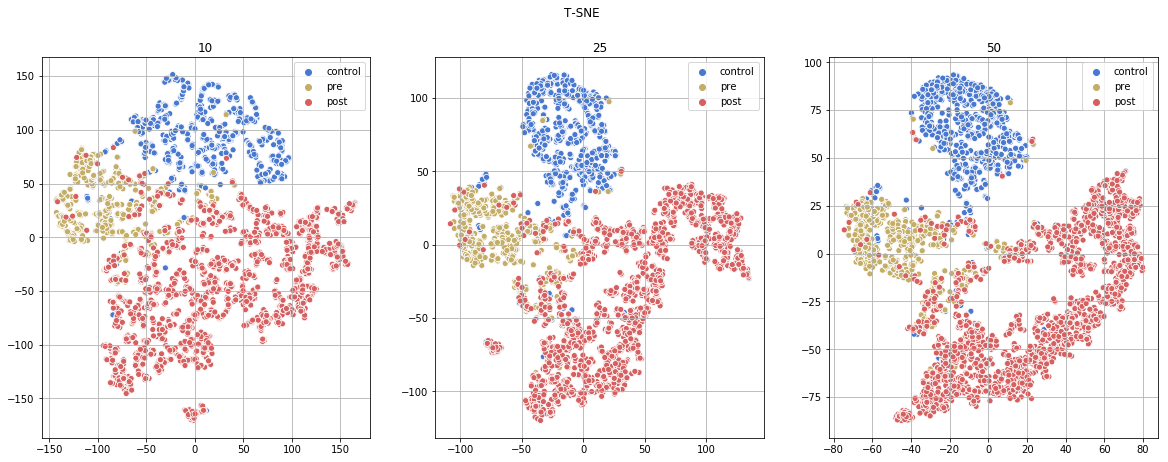

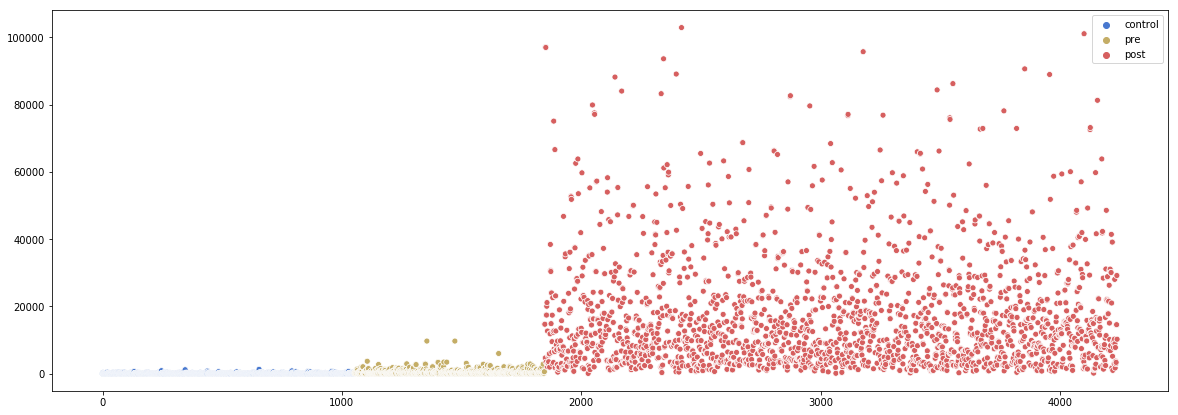

Explained variance ratio:
[0.25857383 0.19762126 0.17244248 0.13050848 0.1227764  0.0629601
 0.02174494 0.01149533 0.00406213 0.00300751]


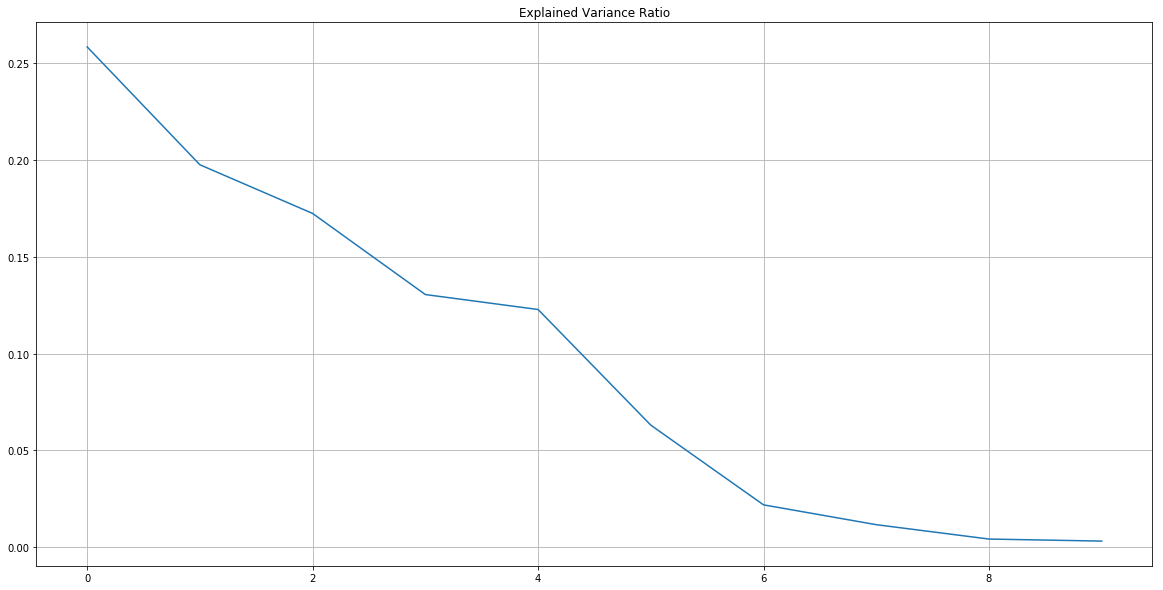


 Min ->  0.49494254376964636


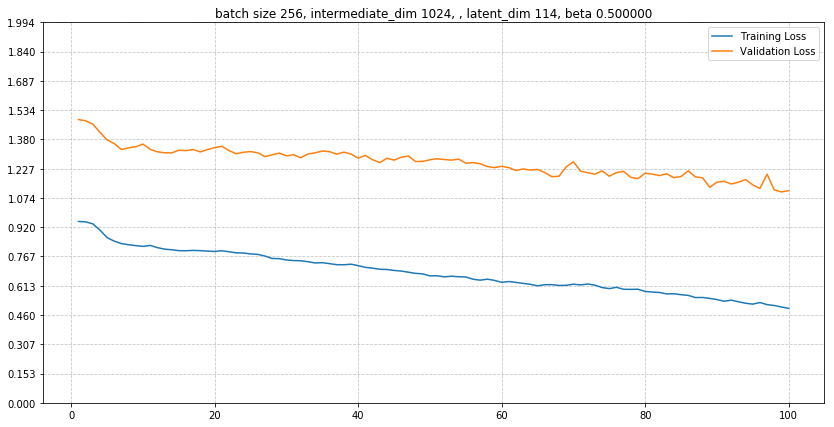

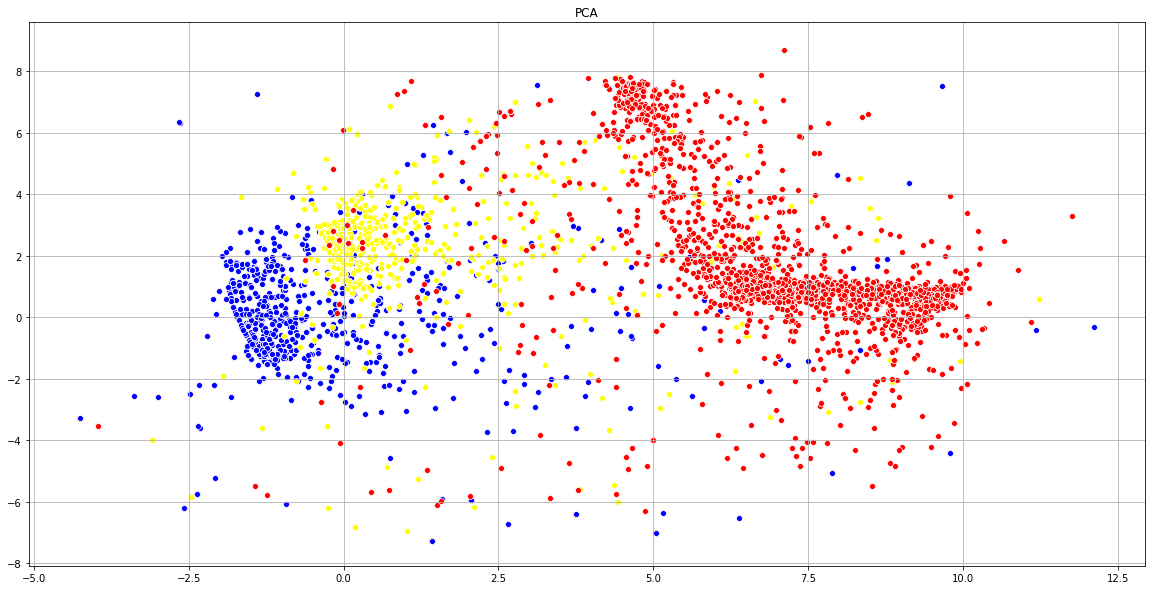

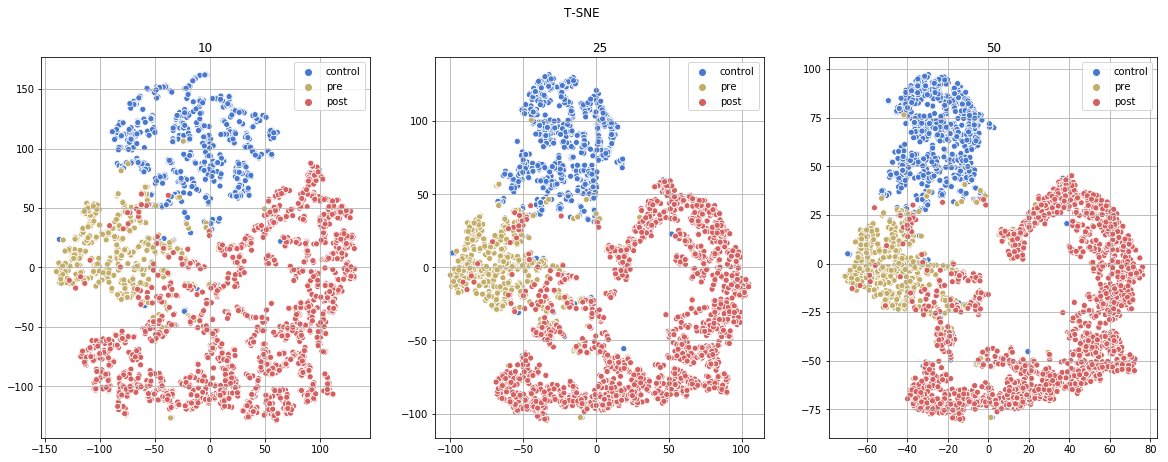

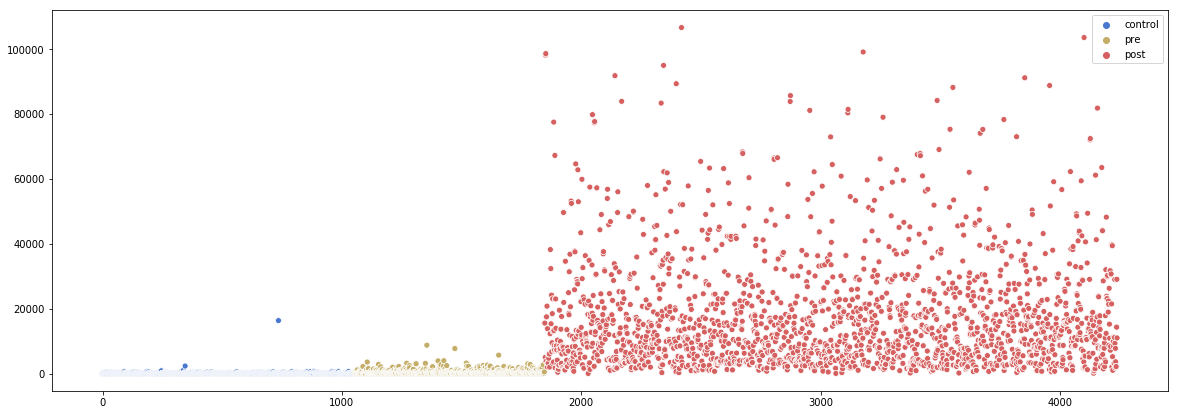

In [19]:
# CHanging the amount of data used to train the machine with controls

%matplotlib inline
_vars = ['caghigh', 'age', 'occupatn', 'finances', 'chores', 'adl', 'carelevl', 'ocularh', 'ocularv','sacinith', 'sacinitv', 'sacvelh', 'sacvelv', 'dysarth', 'tongue','fingtapr', 'fingtapl', 'prosupr','prosupl', 'luria', 
         'rigarmr', 'rigarml','brady', 'dysttrnk',  'dystrue', 'dystlue', 'dystrle', 'dystlle', 'chorface', 'chorbol', 'chortrnk', 'chorrue', 'chorlue', 'chorrle', 'chorlle', 'gait', 'tandem', 'retropls']
#_vars = ['caghigh', 'tfcscore', 'age','depscore', 'irascore', 'aptscore', 'exfscore','psyscore']
#_vars = ['caglow', 'caghigh', 'tfcscore', 'motscore', 'age']
NR_VISITS = 4
control_data, pre_data, post_data, mean, std, control_labels, pre_labels, post_labels = get_data(persons)
do_norm(mean, std, control_data, pre_data, post_data)

batch = 128*2
i_dim = 512*2
l_dim=3*len(_vars)
beta=0.5



#data = np.concatenate((control_data,pre_data,post_data))
#labels = np.concatenate((control_labels, pre_labels, post_labels))
#Model creation

#vae.summary()
for i in [255,511,767,1023]:
    try:
        del vae
        del gen
        del enc
    except:
        pass
    tf.reset_default_graph()
    K.clear_session()
    vae, enc, gen,_,_ = create_vae(len(_vars), NR_VISITS, batch, i_dim, l_dim, 1.0, beta)
    #Shuffling data and labels (subjid)
    data = control_data[:i,:,:]
    labels = control_labels[:i,:]
    data, labels = shuffle(data,labels)

    #Running the model
    history = vae.fit(data, data, epochs=150, validation_split=0.2, batch_size=batch, verbose=0)
    p0 = Graphs.explain_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons, n_components=10)
    #p0.show()
    #plt.clf()
    preds = vae.predict(control_data, batch_size=batch)
    preds_pre = vae.predict(pre_data, batch_size=batch)
    preds_post = vae.predict(post_data, batch_size=batch)

    #Plotting
    _,p1=Graphs.plot_loss(batch,i_dim, l_dim,beta, history)
    #p1.show()
    #plt.clf()
    p2=Graphs.plot_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons)
    #p2.show()
    #plt.clf()
    p3=Graphs.plot_TSNE(enc, control_data, pre_data, post_data, control_labels, pre_labels, post_labels, persons)
    #p3.show()
    #plt.clf()

    p4=Graphs.plot_mse(control_data, preds, pre_data, preds_pre, post_data,preds_post, _vars, mean, std, NR_VISITS)
    #p4.show()
    #plt.clf()

#Shuffling data and labels (subjid)
data = control_data
labels = control_labels
data, labels = shuffle(data,labels)

try:
    del vae
    del gen
    del enc
except:
    pass
tf.reset_default_graph()
K.clear_session()
vae, enc, gen,_,_ = create_vae(len(_vars), NR_VISITS, batch, i_dim, l_dim, 1.0, beta)

#Running the model
history = vae.fit(data, data, epochs=100, validation_split=0.2, batch_size=batch, verbose=0)
p0=Graphs.explain_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons, n_components=10)
#p0.show()
#plt.clf()
preds = vae.predict(control_data, batch_size=batch)
preds_pre = vae.predict(pre_data, batch_size=batch)
preds_post = vae.predict(post_data, batch_size=batch)

#Plotting
_,p1=Graphs.plot_loss(batch,i_dim, l_dim,beta, history)
#p1.plot()
#plt.clf()
p2=Graphs.plot_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons)
#p2.show()
#plt.clf()
p3=Graphs.plot_TSNE(enc, control_data, pre_data, post_data, control_labels, pre_labels, post_labels, persons)
#p3.show()
#plt.clf()
p4=Graphs.plot_mse(control_data, preds, pre_data, preds_pre, post_data,preds_post, _vars, mean, std, NR_VISITS)
#p4.plot()
#plt.clf()



From total data: 3719 controls, 3186 Pre, 8396 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 44 both - 0
Post: caghigh - 28    caglow - 163  both - 0
Underage: Control 4 ; Pre 2 ; Post 25 

From data to be used: 1138 controls, 829 Pre, 2636 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 16 both - 0
Post: caghigh - 6    caglow - 55  both - 0
Underage: Control 2 ; Pre 2 ; Post 6 

Removing the unwanted data from controls 

Removing 72 entries from control data
Old control -> (1138, 4, 7)
New control -> (1066, 4, 7)

Removing the unwanted data from pre 

Removing 23 entries from pre data
Old pre -> (829, 4, 7)
New pre -> (806, 4, 7)

Removing the unwanted data from post 

Removing 165 entries from post data
Old post -> (2636, 4, 7)
New post -> (2471, 4, 7)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #   

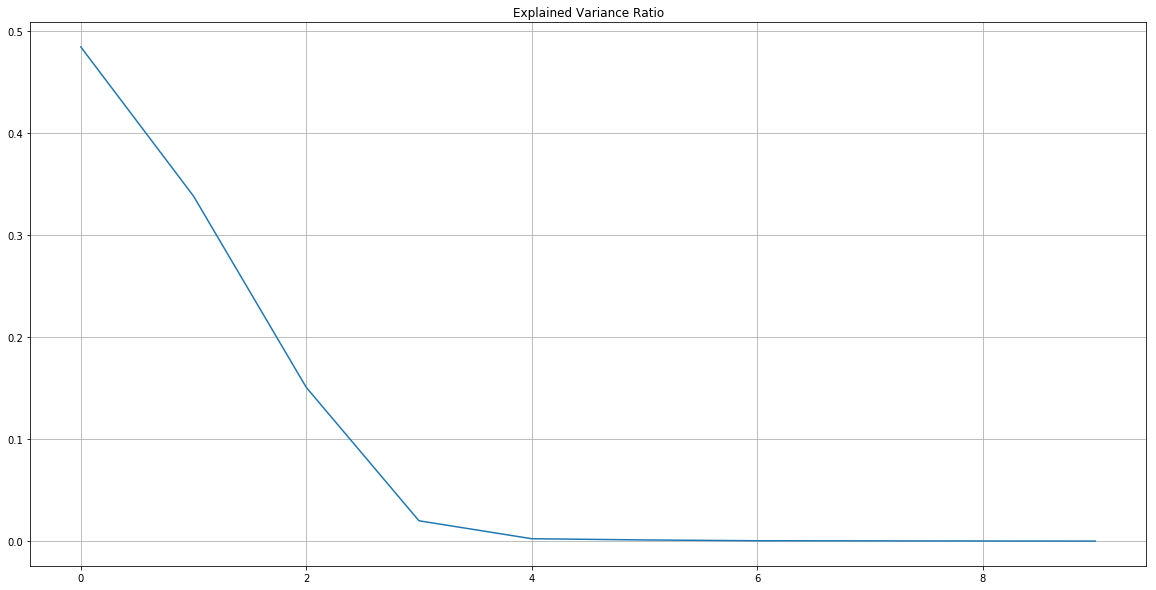


 Min ->  0.501600077174639


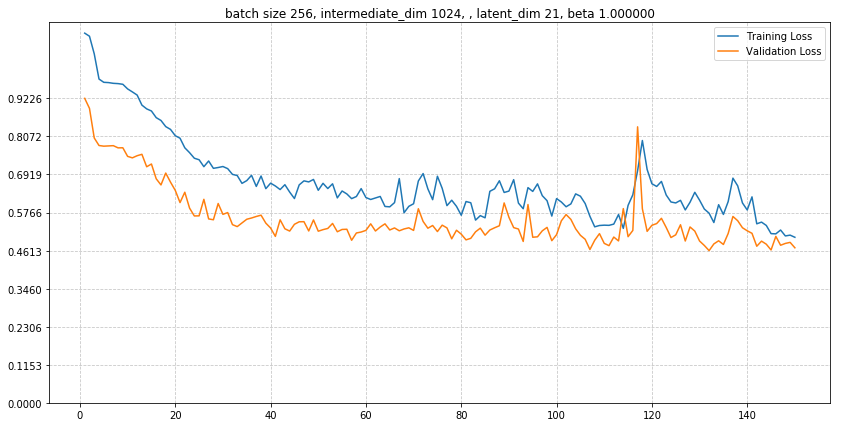

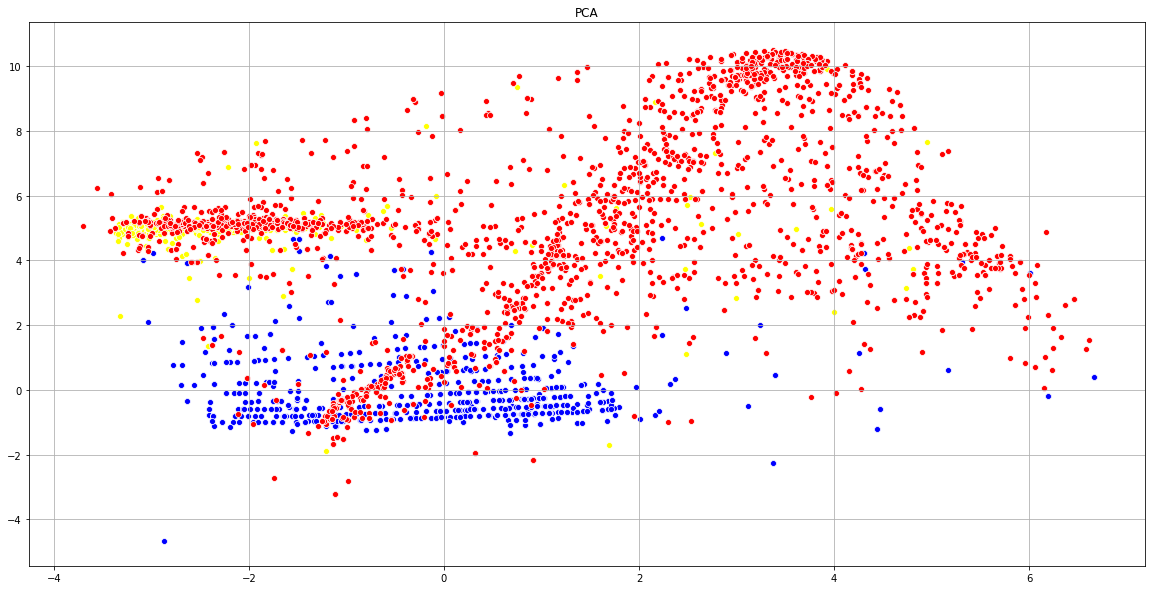

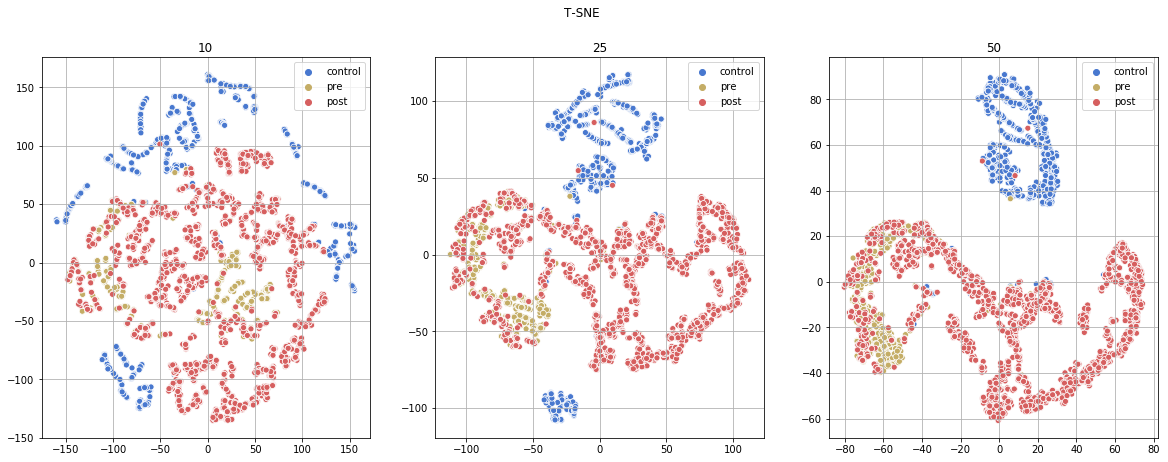

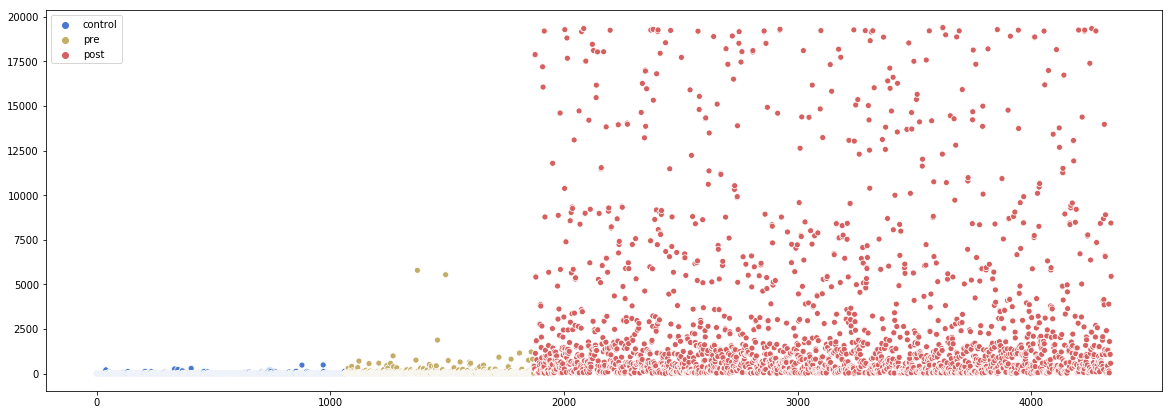

<module 'matplotlib.pyplot' from '/home/miguel/miniconda3/envs/tf36/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [17]:
# Only vars leading to tfc score + age + caghigh

%matplotlib inline
_vars = ['caghigh', 'age', 'occupatn', 'finances', 'chores', 'adl', 'carelevl']

NR_VISITS = 4
control_data, pre_data, post_data, mean, std, control_labels, pre_labels, post_labels = get_data(persons)
do_norm(mean, std, control_data, pre_data, post_data)

batch = 256
i_dim = 1024
l_dim=len(_vars)*3
beta=1

try:
    del vae
    del gen
    del enc
except:
    pass
tf.reset_default_graph()
K.clear_session()

#data = np.concatenate((control_data,pre_data,post_data))
#labels = np.concatenate((control_labels, pre_labels, post_labels))
#Model creation
vae, enc, gen, _,_ = create_vae(len(_vars), NR_VISITS, batch, i_dim, l_dim, 1.0, beta)
vae.summary()

#Shuffling data and labels (subjid)
data = control_data
data = shuffle(data)

#Running the model
history = vae.fit(data, data, epochs=150, validation_split=0.2, batch_size=batch, verbose=0)
p0 = Graphs.explain_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons, n_components=10)
#p0.plot()
preds = vae.predict(control_data, batch_size=batch)
preds_pre = vae.predict(pre_data, batch_size=batch)
preds_post = vae.predict(post_data, batch_size=batch)

#Plotting
_,p1=Graphs.plot_loss(batch,i_dim, l_dim,beta, history)
#p1.plot()
p2=Graphs.plot_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons)
#p2.plot()

p3=Graphs.plot_TSNE(enc, control_data, pre_data, post_data, control_labels, pre_labels, post_labels, persons)
#p3.plot()

Graphs.plot_mse(control_data, preds, pre_data, preds_pre, post_data,preds_post, _vars, mean, std, NR_VISITS)



From total data: 3719 controls, 3186 Pre, 8396 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 44 both - 0
Post: caghigh - 28    caglow - 163  both - 0
Underage: Control 4 ; Pre 2 ; Post 25 

From data to be used: 1138 controls, 829 Pre, 2636 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 16 both - 0
Post: caghigh - 6    caglow - 55  both - 0
Underage: Control 2 ; Pre 2 ; Post 6 

Removing the unwanted data from controls 

Removing 83 entries from control data
Old control -> (1138, 4, 33)
New control -> (1055, 4, 33)

Removing the unwanted data from pre 

Removing 28 entries from pre data
Old pre -> (829, 4, 33)
New pre -> (801, 4, 33)

Removing the unwanted data from post 

Removing 217 entries from post data
Old post -> (2636, 4, 33)
New post -> (2419, 4, 33)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Para

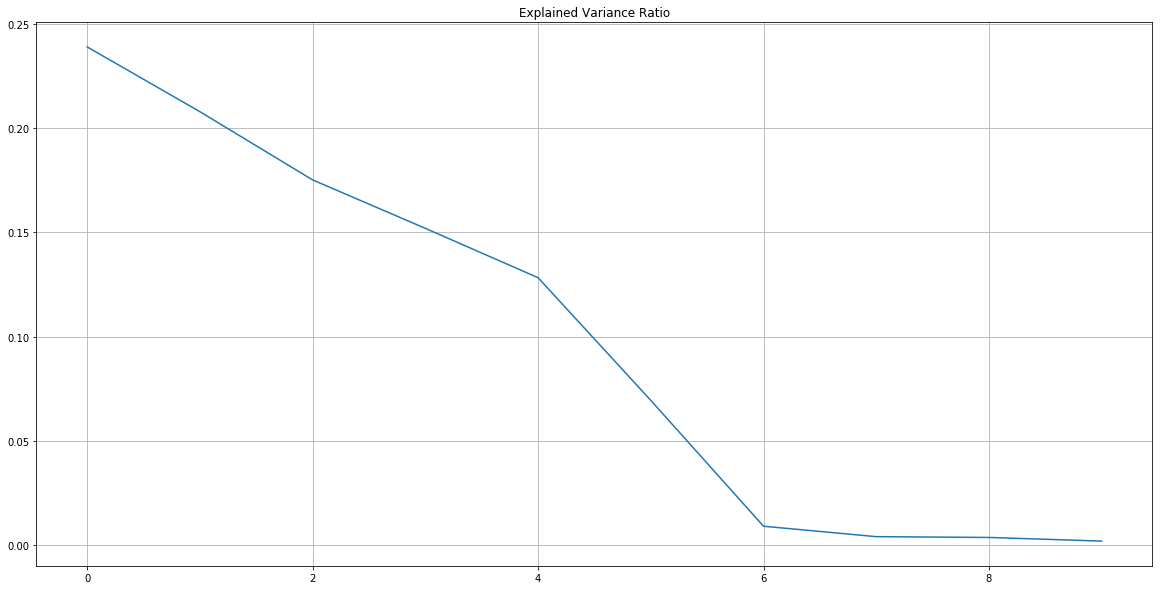


 Min ->  0.5508493457642777


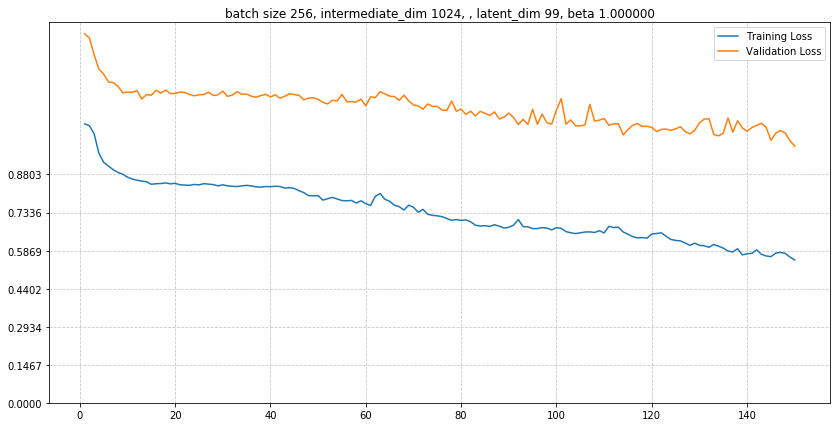

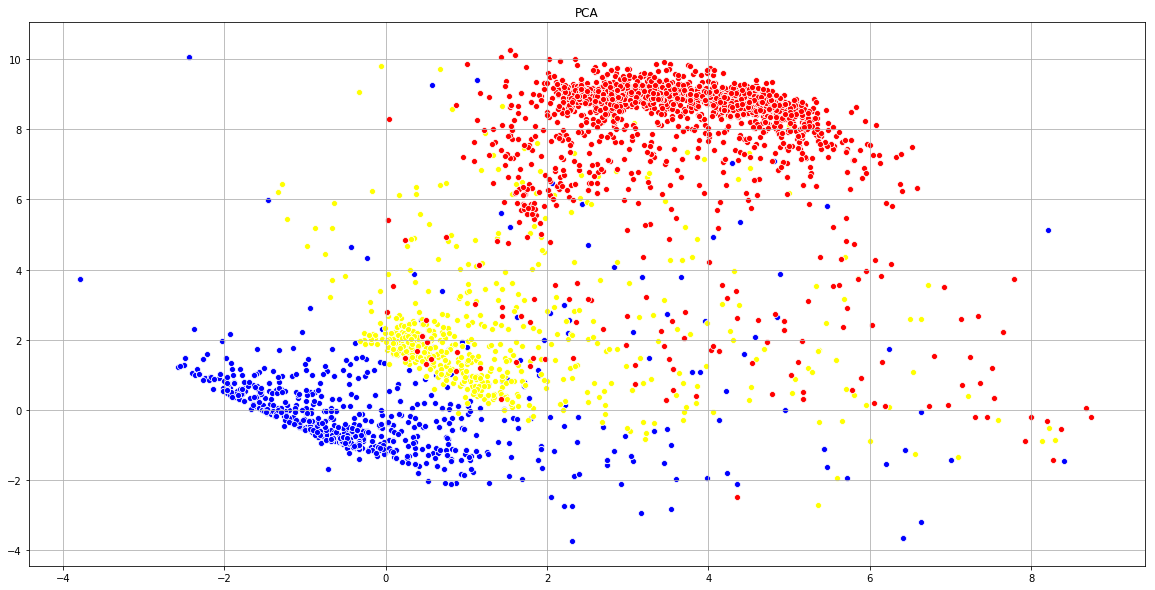

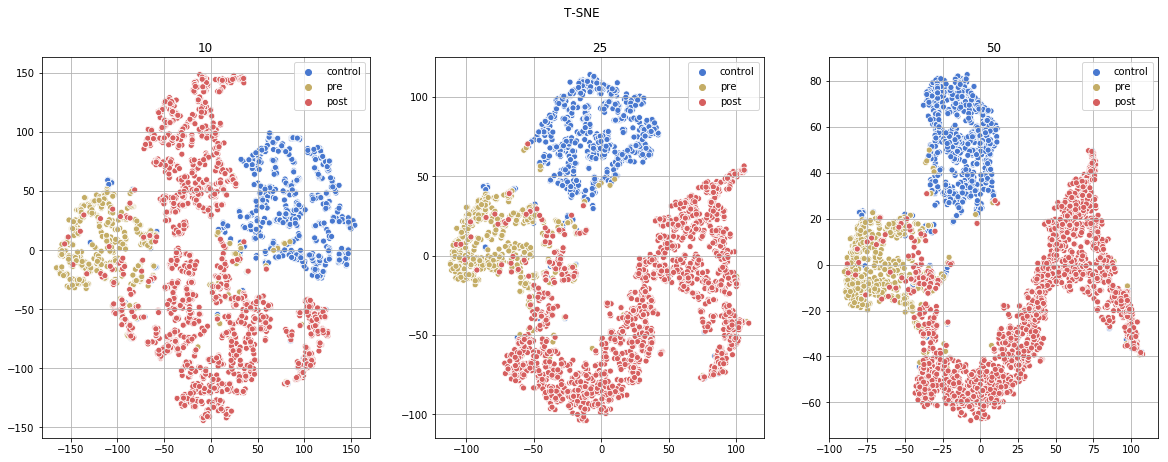

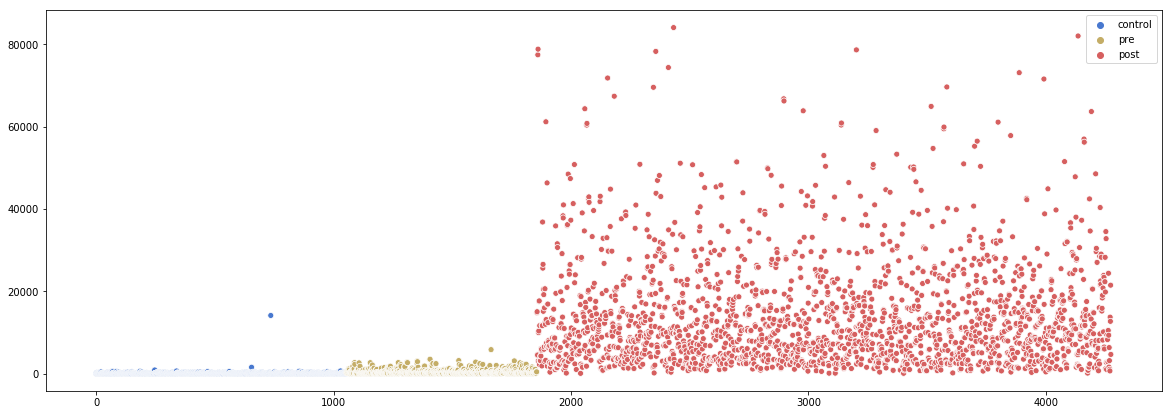

<module 'matplotlib.pyplot' from '/home/miguel/miniconda3/envs/tf36/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [18]:
# Only vars leading to motorscore + age + caghigh

%matplotlib inline
_vars = ['caghigh', 'age', 'ocularh', 'ocularv','sacinith', 'sacinitv', 'sacvelh', 'sacvelv', 'dysarth', 'tongue','fingtapr', 'fingtapl', 'prosupr','prosupl', 'luria', 
         'rigarmr', 'rigarml','brady', 'dysttrnk',  'dystrue', 'dystlue', 'dystrle', 'dystlle', 'chorface', 'chorbol', 'chortrnk', 'chorrue', 'chorlue', 'chorrle', 'chorlle', 'gait', 'tandem', 'retropls']

NR_VISITS = 4
control_data, pre_data, post_data, mean, std, control_labels, pre_labels, post_labels = get_data(persons)
do_norm(mean, std, control_data, pre_data, post_data)

batch = 256
i_dim = 1024
l_dim=len(_vars)*3
beta=1

try:
    del vae
    del gen
    del enc
except:
    pass
tf.reset_default_graph()
K.clear_session()

#data = np.concatenate((control_data,pre_data,post_data))
#labels = np.concatenate((control_labels, pre_labels, post_labels))
#Model creation
vae, enc, gen, _,_ = create_vae(len(_vars), NR_VISITS, batch, i_dim, l_dim, 1.0, beta)
vae.summary()

#Shuffling data and labels (subjid)
data = control_data
data = shuffle(data)

#Running the model
history = vae.fit(data, data, epochs=150, validation_split=0.2, batch_size=batch, verbose=0)
p0 = Graphs.explain_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons, n_components=10)
#p0.plot()
preds = vae.predict(control_data, batch_size=batch)
preds_pre = vae.predict(pre_data, batch_size=batch)
preds_post = vae.predict(post_data, batch_size=batch)

#Plotting
_,p1=Graphs.plot_loss(batch,i_dim, l_dim,beta, history)
#p1.plot()
p2=Graphs.plot_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons)
#p2.plot()

p3=Graphs.plot_TSNE(enc, control_data, pre_data, post_data, control_labels, pre_labels, post_labels, persons)
#p3.plot()

Graphs.plot_mse(control_data, preds, pre_data, preds_pre, post_data,preds_post, _vars, mean, std, NR_VISITS)

From total data: 3719 controls, 3186 Pre, 8396 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 44 both - 0
Post: caghigh - 28    caglow - 163  both - 0
Underage: Control 4 ; Pre 2 ; Post 25 

From data to be used: 1138 controls, 829 Pre, 2636 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 16 both - 0
Post: caghigh - 6    caglow - 55  both - 0
Underage: Control 2 ; Pre 2 ; Post 6 

Removing the unwanted data from controls 

Removing 84 entries from control data
Old control -> (1138, 4, 38)
New control -> (1054, 4, 38)

Removing the unwanted data from pre 

Removing 36 entries from pre data
Old pre -> (829, 4, 38)
New pre -> (793, 4, 38)

Removing the unwanted data from post 

Removing 243 entries from post data
Old post -> (2636, 4, 38)
New post -> (2393, 4, 38)

Tensor("dense_1/BiasAdd:0", shape=(?, 114), dtype=float32)
_________________________________________________________________________________________________

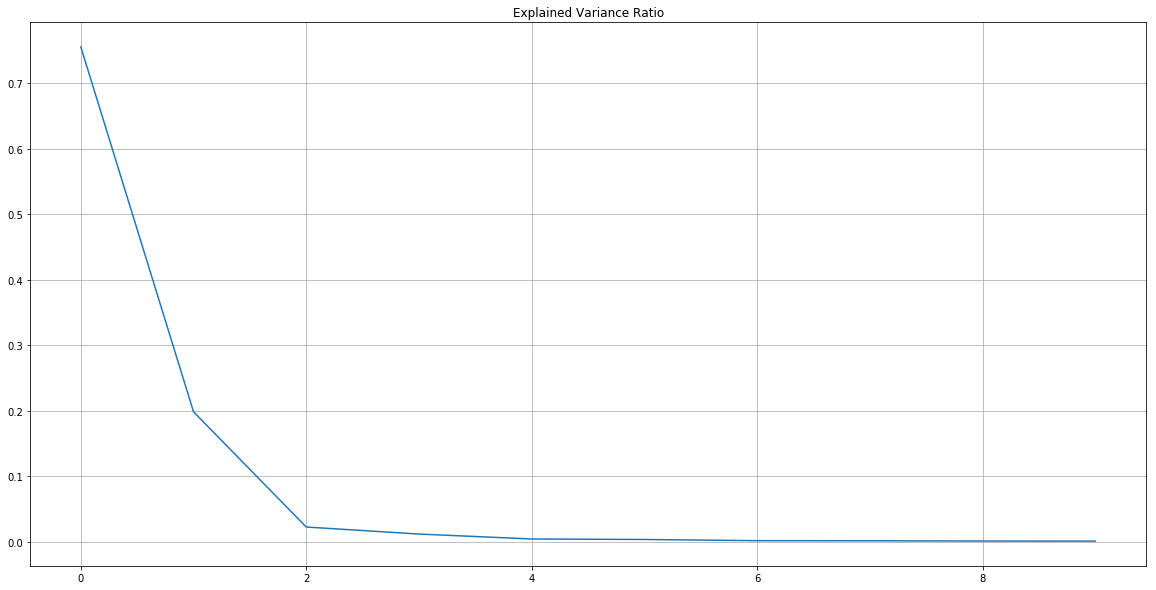


 Min ->  0.7724793983241134


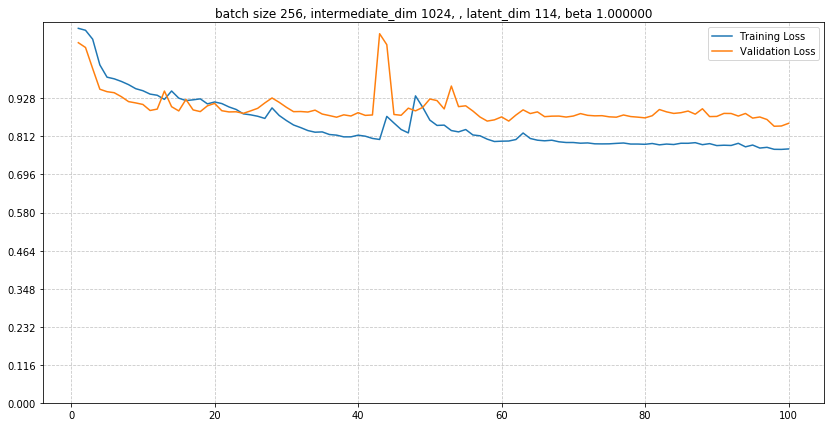

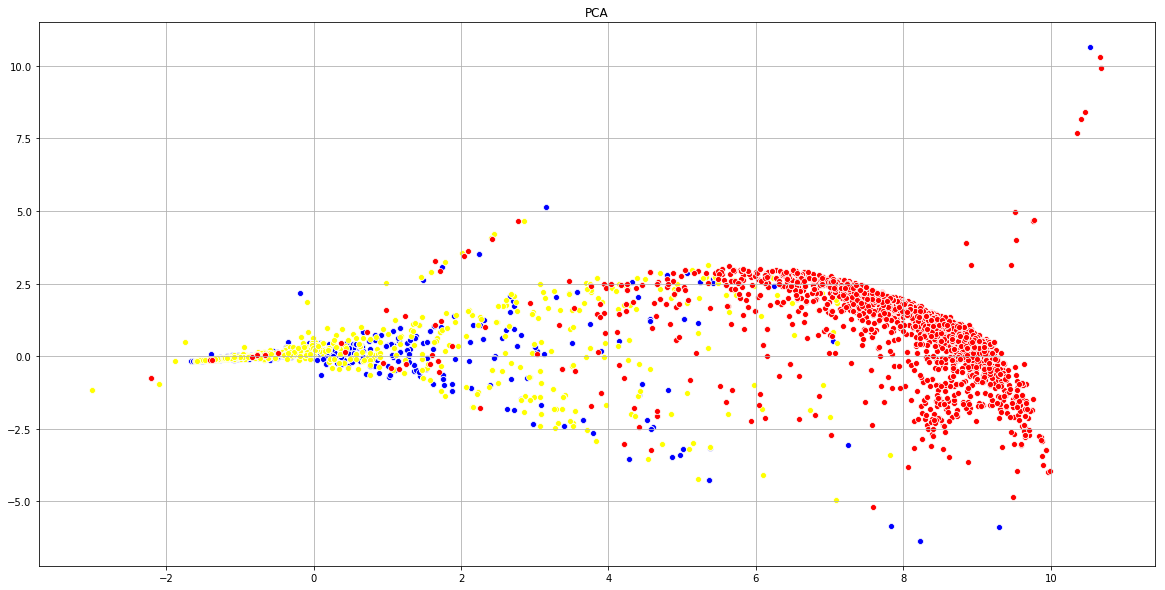

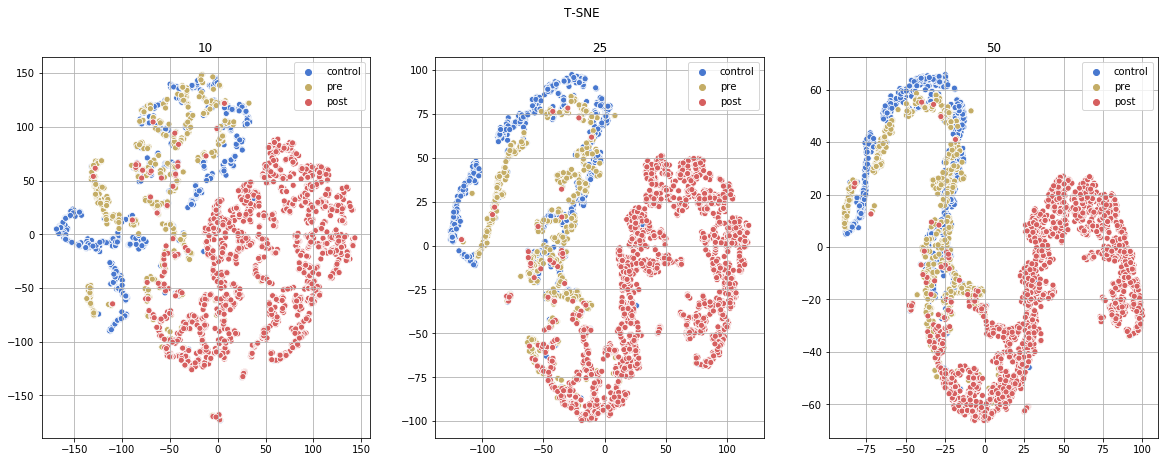

ValueError: all the input arrays must have same number of dimensions

In [13]:
# Using data generated to have a large enough number of control data in comparison with the remaining (and also post)

%matplotlib inline
_vars = ['caghigh', 'age', 'occupatn', 'finances', 'chores', 'adl', 'carelevl', 'ocularh', 'ocularv','sacinith', 'sacinitv', 'sacvelh', 'sacvelv', 'dysarth', 'tongue','fingtapr', 'fingtapl', 'prosupr','prosupl', 'luria', 
         'rigarmr', 'rigarml','brady', 'dysttrnk',  'dystrue', 'dystlue', 'dystrle', 'dystlle', 'chorface', 'chorbol', 'chortrnk', 'chorrue', 'chorlue', 'chorrle', 'chorlle', 'gait', 'tandem', 'retropls']
#_vars = ['caghigh', 'tfcscore', 'age','depscore', 'irascore', 'aptscore', 'exfscore','psyscore']
#_vars = ['caglow', 'caghigh', 'tfcscore', 'motscore', 'age']
NR_VISITS = 4
control_data, pre_data, post_data, mean, std, control_labels, pre_labels, post_labels = get_data(persons)
do_norm(mean, std, control_data, pre_data, post_data)

batch = 256
i_dim = 1024
l_dim=len(_vars)*3
beta=1

try:
    del vae
    del gen
    del enc
except:
    pass
tf.reset_default_graph()
K.clear_session()

#data = np.concatenate((control_data,pre_data,post_data))
#labels = np.concatenate((control_labels, pre_labels, post_labels))
#Model creation
vae, enc, gen, mean, z_log_sigma = create_vae(len(_vars), NR_VISITS, batch, i_dim, l_dim, 1.0, beta)
print(mean)
vae.summary()

#Shuffling data and labels (subjid)
data = control_data
data, labels = shuffle(data,labels)

#Running the model
history = vae.fit(data, data, epochs=100, validation_split=0.2, batch_size=batch, verbose=0)
p0 = Graphs.explain_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons, n_components=10)
#p0.plot()
preds = vae.predict(control_data, batch_size=batch)
preds_pre = vae.predict(pre_data, batch_size=batch)
preds_post = vae.predict(post_data, batch_size=batch)

#Plotting
_,p1=Graphs.plot_loss(batch,i_dim, l_dim,beta, history)
#p1.plot()
p2=Graphs.plot_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons)
#p2.plot()

p3=Graphs.plot_TSNE(enc, control_data, pre_data, post_data, control_labels, pre_labels, post_labels, persons)
#p3.plot()

#Graphs.plot_mse(control_data, preds, pre_data, preds_pre, post_data,preds_post, _vars, mean, std, NR_VISITS)

#Generate data and run it again:
n_gen_control = post_data.shape[0] - control_data.shape[0]
n_gen_pre = post_data.shape[0] - pre_data.shape[0]
gen_control = np.zeros(shape=(n_gen_control,NR_VISITS,len(_vars)))
gen_pre = np.zeros(shape=(n_gen_pre, NR_VISITS, len(_vars)))
#for i in range(n_gen_control):
    
#for i,c in enumerate(g_val): 
  #  gen_control = gen.predict()

gen_pre = gen.predict

new_control = np.concatenate((control_data,gen_control))
new_pre = np.concatenate((pre_data, gen_pre))
data = np.concatenate((new_control,new_pre,post_data))

try:
    del vae
    del gen
    del enc
except:
    pass
tf.reset_default_graph()
K.clear_session()
vae, enc, gen = create_vae(len(_vars), NR_VISITS, batch, i_dim, l_dim, 1.0, beta)
vae.summary()

#Running the model
history = vae.fit(data, data, epochs=150, validation_split=0.2, batch_size=batch, verbose=0)
p0 = Graphs.explain_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons, n_components=10)
#p0.plot()
preds = vae.predict(control_data, batch_size=batch)
preds_pre = vae.predict(pre_data, batch_size=batch)
preds_post = vae.predict(post_data, batch_size=batch)

#Plotting
_,p1=Graphs.plot_loss(batch,i_dim, l_dim,beta, history)
#p1.plot()
p2=Graphs.plot_PCA(enc, control_data, pre_data, post_data,control_labels, pre_labels, post_labels, persons)
#p2.plot()

p3=Graphs.plot_TSNE(enc, control_data, pre_data, post_data, control_labels, pre_labels, post_labels, persons)
#p3.plot()
